# 데이터 불러오기

In [1]:
### 필요한 라이브러리 임폴트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from keras.optimizers import Adam
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/KDT/본 프로젝트'

Mounted at /content/drive
/content/drive/MyDrive/KDT/본 프로젝트


In [5]:
### pandas read_csv()함수를 이용, 데이터 셋 생성하기
df = pd.read_csv('0727_Seoul_preprocessed.csv', encoding = 'cp949', index_col=0)

# 결과 확인
print(df.head())
print('='*100)
print(df.tail())
print('='*100)
print(df.info())

   기준_년_코드  기준_분기_코드   자치구    행정동  대분류    상권_코드    중분류         업종명  총_점포수  \
0     2022         1  서대문구  북가좌2동  서비스  2110499     의료         한의원      1   
1     2022         1   노원구   공릉1동   소매  2110433  의류/잡화          안경      1   
2     2022         1   마포구   성산1동   소매  2110548   전자기기  컴퓨터및주변장치판매      4   
3     2022         1   은평구    대조동  서비스  2110481     미용       피부관리실      3   
4     2022         1  영등포구   신길6동  서비스  2110804     교육        예술학원      5   

   점포_수  ...  개업_점포_수  폐업_률  폐업_점포_수  프랜차이즈_점포_수   총_매출_금액  분기당_매출_금액  \
0     1  ...        0     0        0           0  54003138   54003138   
1     1  ...        0     0        0           0  16150022   16150022   
2     4  ...        0     0        0           0  89813767   89813767   
3     3  ...        1     0        0           0   4619842    4619842   
4     5  ...        0     0        0           0   5946480    5946480   

   주중_매출_금액  주말_매출_금액  남성_매출_금액  여성_매출_금액  
0  35504845  18498293   8791373  45211765  
1  1467465

In [6]:
# 이런저런 전처리

# 컬럼명 바꾸기
df = df.rename(columns = {'남성_매출_금액' : '남성매출금액',
                          '여성_매출_금액' : '여성매출금액',
                          '점포_수' : '점포수',
                          '총_점포수' : '총 점포수',
                          '개업_점포_수' : '개업점포수',
                          '폐업_점포_수' : '폐업점포수',
                          '프랜차이즈_점포_수' : '프랜차이즈 수',
                          '개업_율' : '개업률',
                          '폐업_률' : '폐업률'})

# df에 분기, 상반기/하반기 추가
df['분기'] = df['기준_년_코드'].astype(str) + '-' + df['기준_분기_코드'].astype(str)

df.columns

Index(['기준_년_코드', '기준_분기_코드', '자치구', '행정동', '대분류', '상권_코드', '중분류', '업종명',
       '총 점포수', '점포수', '순점포증감률', '개업률', '개업점포수', '폐업률', '폐업점포수', '프랜차이즈 수',
       '총_매출_금액', '분기당_매출_금액', '주중_매출_금액', '주말_매출_금액', '남성매출금액', '여성매출금액',
       '분기'],
      dtype='object')

In [7]:
# 분기별 내림차순 정렬
df = df.sort_values(by=['기준_년_코드', '기준_분기_코드'], ascending=True).reset_index().drop('index', axis=1)
# df

In [8]:
# 신촌동만 남김
df_sin = df[df.행정동=='신촌동']

# 신촌동에 중분류 업종 중 '주유', '여행', '기술', '정비/수리' 는 18년도에만 매출이 찍혀있으므로, 제외하도록 하자.
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '주유'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '여행'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '기술'].index)
df_sin = df_sin.drop(df_sin[df_sin.중분류 == '정비/수리'].index).reset_index().drop('index', axis=1)

# df_sin

In [9]:
# 분기별 업종별 매출금액 합치기

df_sin_quarter = df_sin.groupby(['분기', '대분류', '중분류', '업종명', '행정동'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()
df_sin_quarter

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,서비스,교육,독서실,신촌동,169054586,18,1,0
1,2017-1,서비스,교육,스포츠강습,신촌동,795837623,23,1,0
2,2017-1,서비스,교육,예술학원,신촌동,1162571945,28,1,0
3,2017-1,서비스,교육,외국어학원,신촌동,3196308868,24,2,2
4,2017-1,서비스,교육,일반교습학원,신촌동,762815407,9,1,3
...,...,...,...,...,...,...,...,...,...
1339,2022-4,외식,식사류,패스트푸드점,신촌동,3057584360,83,0,4
1340,2022-4,외식,식사류,한식음식점,신촌동,29617724330,435,8,12
1341,2022-4,외식,주류,호프-간이주점,신촌동,7366806532,171,1,6
1342,2022-4,외식,카페/베이커리,제과점,신촌동,1302230221,48,3,2


# 일반의류

In [10]:
# 일반의류만 남기기
sin_clothes = df_sin_quarter[df_sin_quarter.업종명 == '일반의류'].reset_index().drop('index', axis=1)
sin_clothes

,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수
0,2017-1,소매,의류/잡화,일반의류,신촌동,14874336524,494,15,25
1,2017-2,소매,의류/잡화,일반의류,신촌동,20172548016,492,10,12
2,2017-3,소매,의류/잡화,일반의류,신촌동,18334748922,481,7,18
3,2017-4,소매,의류/잡화,일반의류,신촌동,18097709389,474,7,14
4,2018-1,소매,의류/잡화,일반의류,신촌동,13681846686,465,7,16
5,2018-2,소매,의류/잡화,일반의류,신촌동,16793793365,464,8,9
6,2018-3,소매,의류/잡화,일반의류,신촌동,12349739322,460,14,18
7,2018-4,소매,의류/잡화,일반의류,신촌동,13823847354,456,4,8
8,2019-1,소매,의류/잡화,일반의류,신촌동,7677670701,445,11,22
9,2019-2,소매,의류/잡화,일반의류,신촌동,10667986159,440,8,13


## 지표 만들기 : 성장성, 시장성, 순점포증감률

In [11]:
# 기초구역 단위별 선택 업종의 전분기 대비 당기의 매출 증감률을 비교하여 성장 정도를 판단
# 성장성 = 당기 매출액 / 전분기 매출액

# 성장성 추가
# shift() 사용. 참고 : https://seong6496.tistory.com/216

sin_clothes['성장성'] = sin_clothes['분기당_매출_금액'] / sin_clothes['분기당_매출_금액'].shift(1)
# 성장성이 1 이하면 지난분기 대비 이번분기 매출이 줄어든 것. 1 이상이어야 해당 분기 매출 상승.


# # 17년도 1분기 성장성 값은 1로 임의로 정한다. 구할 수가 없어서...
sin_clothes['성장성'][0] = 1

sin_clothes

<ipython-input-11-122a9babbc1e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_clothes['성장성'][0] = 1


,분기,대분류,중분류,업종명,행정동,분기당_매출_금액,총 점포수,개업점포수,폐업점포수,성장성
0,2017-1,소매,의류/잡화,일반의류,신촌동,14874336524,494,15,25,1.000000
1,2017-2,소매,의류/잡화,일반의류,신촌동,20172548016,492,10,12,1.356198
2,2017-3,소매,의류/잡화,일반의류,신촌동,18334748922,481,7,18,0.908896
3,2017-4,소매,의류/잡화,일반의류,신촌동,18097709389,474,7,14,0.987072
4,2018-1,소매,의류/잡화,일반의류,신촌동,13681846686,465,7,16,0.755999
5,2018-2,소매,의류/잡화,일반의류,신촌동,16793793365,464,8,9,1.227451
6,2018-3,소매,의류/잡화,일반의류,신촌동,12349739322,460,14,18,0.735375
7,2018-4,소매,의류/잡화,일반의류,신촌동,13823847354,456,4,8,1.119363
8,2019-1,소매,의류/잡화,일반의류,신촌동,7677670701,445,11,22,0.555393
9,2019-2,소매,의류/잡화,일반의류,신촌동,10667986159,440,8,13,1.389482


In [12]:
# 개업률, 폐업률, 순점포증감률 추가

sin_clothes['개업률'] = (sin_clothes['개업점포수'] / sin_clothes['총 점포수']) * 100
sin_clothes['폐업률'] = (sin_clothes['폐업점포수'] / sin_clothes['총 점포수']) * 100
sin_clothes['순점포증감률'] = ((sin_clothes['개업점포수'] - sin_clothes['폐업점포수']) / sin_clothes['총 점포수']) * 100

# sin_clothes

In [13]:
# 시장성 추가
# 기초구역 단위별 점포당 평균 매출을 시군구의 평균 매출과 비교하여 시군구 평균 대비 시장성을 판단
# 시장성 = (행정동 내 분기 매출액 / 분기 점포수) - (자치구 내 분기 매출액 / 분기 점포수)



################################################################################################################################################################################################

# 자치구 평균 매출을 구하기 위해, 원본 데이터로 잠깐 작업하겠습니다
df_seo = df[df['자치구'] == '서대문구']

# 자치구 분기별 업종별 매출금액 합치기
df_seo_quarter = df_seo.groupby(['분기', '자치구', '대분류', '중분류', '업종명'])['분기당_매출_금액', '총 점포수', '개업점포수', '폐업점포수'].sum().reset_index()

# 일반의류만 남기기
seo_clothes = df_seo_quarter[df_seo_quarter['업종명'] == '일반의류'].reset_index()

################################################################################################################################################################################################

sin_clothes['시장성'] = (sin_clothes['분기당_매출_금액'] / sin_clothes['총 점포수']) - (seo_clothes['분기당_매출_금액'] / seo_clothes['총 점포수'])

sin_clothes = sin_clothes[['분기', '업종명','분기당_매출_금액', '성장성', '순점포증감률', '시장성']]
sin_clothes

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반의류,14874336524,1.000000,-2.024291,-1.923574e+06
1,2017-2,일반의류,20172548016,1.356198,-0.406504,4.282530e+05
2,2017-3,일반의류,18334748922,0.908896,-2.286902,3.864793e+06
3,2017-4,일반의류,18097709389,0.987072,-1.476793,6.838851e+05
4,2018-1,일반의류,13681846686,0.755999,-1.935484,-1.853374e+06
5,2018-2,일반의류,16793793365,1.227451,-0.215517,-2.730931e+06
6,2018-3,일반의류,12349739322,0.735375,-0.869565,-2.090695e+05
7,2018-4,일반의류,13823847354,1.119363,-0.877193,-5.195801e+06
8,2019-1,일반의류,7677670701,0.555393,-2.471910,-3.294589e+06
9,2019-2,일반의류,10667986159,1.389482,-1.136364,-2.422348e+06


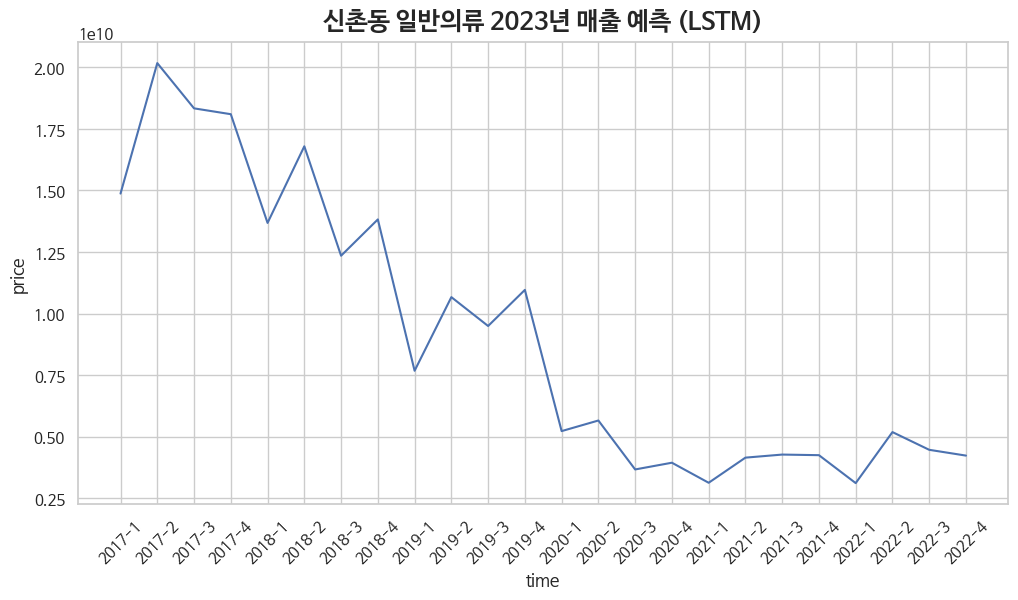

In [15]:
### seaborn lineplot을 이용, 전체 매출 시각화

# 시각화에 필요한 matplotlib.pyplot, seaborn 라이브러리 임폴트
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화

sns.set(style="whitegrid", color_codes=True, font='NanumBarunGothic')

plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'])
plt.title('신촌동 일반의류 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xlabel('time')
plt.xticks(rotation=45)
plt.ylabel('price')
plt.show()

## 23년 1분기 매출 예측

In [16]:
### X / y 데이터 생성
X = sin_clothes[['성장성', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -1.923574e+06 -2.024291
1   1.356198  4.282530e+05 -0.406504
2   0.908896  3.864793e+06 -2.286902
3   0.987072  6.838851e+05 -1.476793
4   0.755999 -1.853374e+06 -1.935484
5   1.227451 -2.730931e+06 -0.215517
6   0.735375 -2.090695e+05 -0.869565
7   1.119363 -5.195801e+06 -0.877193
8   0.555393 -3.294589e+06 -2.471910
9   1.389482 -2.422348e+06 -1.136364
10  0.890083  2.349194e+05 -2.320186
11  1.154413 -1.800125e+06 -0.692841
12  0.476817 -3.083545e+06 -2.625298
13  1.082353 -4.613689e+06 -0.968523
14  0.648603 -3.003963e+06 -1.719902
15  1.074520 -5.311729e+06 -2.261307
16  0.793516 -3.875800e+06 -1.295337
17  1.326198 -5.192278e+06 -1.578947
18  1.029972 -2.441964e+06 -1.612903
19  0.994319 -4.963014e+06 -1.917808
20  0.733027 -4.235434e+06 -2.191781
21  1.665141 -8.681121e+06 -0.831025
22  0.861278 -4.267715e+06 -0.837989
23  0.947323 -1.015001e+07 -0.561798
---------------------------------------------------------------------------

In [17]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [18]:
### 시계열 분석에 적합한 데이터를 만들어 주는 함수 정의
def make_dataset(X, y, window_size=10):
    X_data = []
    y_data = []
    for start in np.arange(len(X) - window_size):
        stop = start + window_size
        X_data.append(X[start:stop, :])
        y_data.append(y[stop])
    return np.array(X_data), np.array(y_data)




### 시계열 분석에서 마지막 테스트 데이터를 만들어 주는 함수 정의
def make_last_dataset(X, window_size=10):
    X_data_last = []
    for start in np.arange(len(X) - window_size +1):
        stop = start + window_size
        X_data_last.append(X[start:stop, :])
    return X_data_last[-1]

In [19]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [20]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.32353224 0.41971998 0.74168957]
 [0.39594092 0.         0.85630209]]


In [21]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [22]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
# model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [23]:
### 모델 학습

# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4327
Epoch 1: val_loss improved from inf to 0.00923, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.4327 - val_loss: 0.0092
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4168
Epoch 2: val_loss improved from 0.00923 to 0.00746, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.4168 - val_loss: 0.0075
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4015
Epoch 3: val_loss improved from 0.00746 to 0.00595, saving model to stock_model.h5
1/1 [==============================] - 0s 77ms/step - loss: 0.4015 - val_loss: 0.0060
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3867
Epoch 4: val_loss improved from 0.00595 to 0.00468, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.3867 - val_loss: 0.0047
Epoch 5/100
1/1 [=================

In [24]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 827ms/step
[[0.07097469]
 [0.0637446 ]
 [0.07191892]
 [0.08883503]]


In [25]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.000000,0.070975
2022-2,0.121455,0.063745
2022-3,0.079276,0.071919
2022-4,0.065481,0.088835


In [26]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_clothes의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.000000,0.070975,3114749463,4.325422e+09,-1.210672e+09
2022-2,0.121455,0.063745,5186497830,4.202092e+09,9.844058e+08
2022-3,0.079276,0.071919,4467018071,4.341528e+09,1.254900e+08
2022-4,0.065481,0.088835,4231710213,4.630079e+09,-3.983693e+08


### 결과

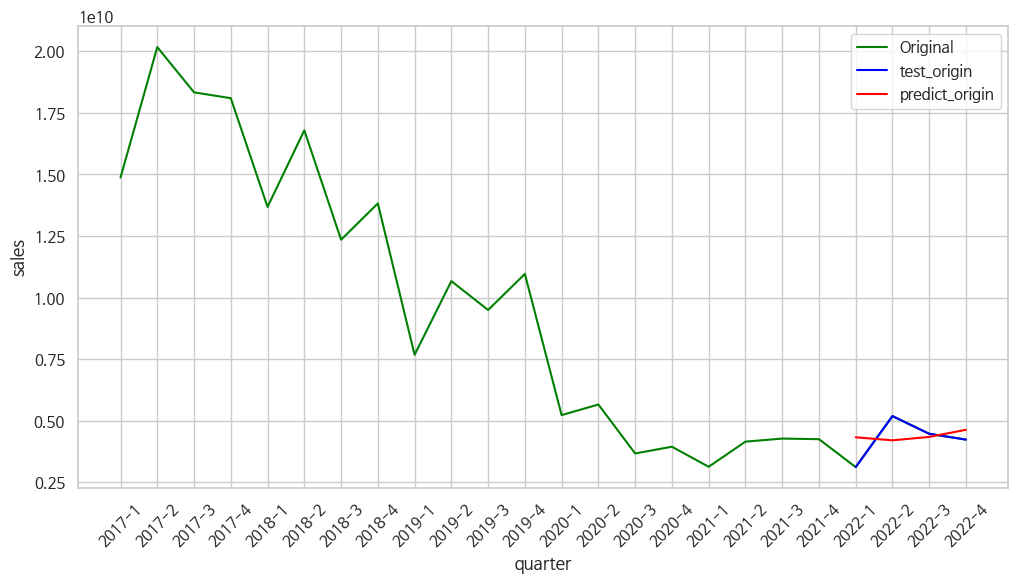

In [27]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [28]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -1.247864e+08
std      9.214013e+08
min     -1.210672e+09
25%     -6.014450e+08
50%     -1.364396e+08
75%      3.402190e+08
max      9.844058e+08
dtype: float64

In [29]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 22ms/step
[[0.08175022]]
--------------------------------------------------------------------------------
예측된 매출  : 4509228544.0 


## 23년 1분기 성장성 예측

In [30]:
# 성장을 예측하기 위한 지표로는 성장성, 안정성, 시장성, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

      분기당_매출_금액           시장성    순점포증감률
0   14874336524 -1.923574e+06 -2.024291
1   20172548016  4.282530e+05 -0.406504
2   18334748922  3.864793e+06 -2.286902
3   18097709389  6.838851e+05 -1.476793
4   13681846686 -1.853374e+06 -1.935484
5   16793793365 -2.730931e+06 -0.215517
6   12349739322 -2.090695e+05 -0.869565
7   13823847354 -5.195801e+06 -0.877193
8    7677670701 -3.294589e+06 -2.471910
9   10667986159 -2.422348e+06 -1.136364
10   9495393370  2.349194e+05 -2.320186
11  10961609488 -1.800125e+06 -0.692841
12   5226683301 -3.083545e+06 -2.625298
13   5657115497 -4.613689e+06 -0.968523
14   3669221952 -3.003963e+06 -1.719902
15   3942652100 -5.311729e+06 -2.261307
16   3128557349 -3.875800e+06 -1.295337
17   4149084973 -5.192278e+06 -1.578947
18   4273441350 -2.441964e+06 -1.612903
19   4249163196 -4.963014e+06 -1.917808
20   3114749463 -4.235434e+06 -2.191781
21   5186497830 -8.681121e+06 -0.831025
22   4467018071 -4.267715e+06 -0.837989
23   4231710213 -1.015001e+07 -0.561798


In [31]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [32]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [33]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.07927568 0.41971998 0.74168957]
 [0.06548094 0.         0.85630209]]


In [34]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [35]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2450
Epoch 1: val_loss improved from inf to 0.20063, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.2450 - val_loss: 0.2006
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2330
Epoch 2: val_loss improved from 0.20063 to 0.19312, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.2330 - val_loss: 0.1931
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2216
Epoch 3: val_loss improved from 0.19312 to 0.18592, saving model to stock_model.h5
1/1 [==============================] - 0s 133ms/step - loss: 0.2216 - val_loss: 0.1859
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.2107
Epoch 4: val_loss improved from 0.18592 to 0.17898, saving model to stock_model.h5
1/1 [==============================] - 0s 126ms/step - loss: 0.2107 - val_loss: 0.1790
Epoch 5/100
1/1 [==============

In [37]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 780ms/step
[[0.32600018]
 [0.2876729 ]
 [0.29993337]
 [0.36960444]]


In [38]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.215606,0.326000
2022-2,1.000000,0.287673
2022-3,0.323532,0.299933
2022-4,0.395941,0.369604


In [39]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 3].values       # 성장성이 sin_clothes의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.215606,0.326000,0.733027,0.864211,-0.131184
2022-2,1.000000,0.287673,1.665141,0.818666,0.846475
2022-3,0.323532,0.299933,0.861278,0.833235,0.028043
2022-4,0.395941,0.369604,0.947323,0.916027,0.031296


### 결과

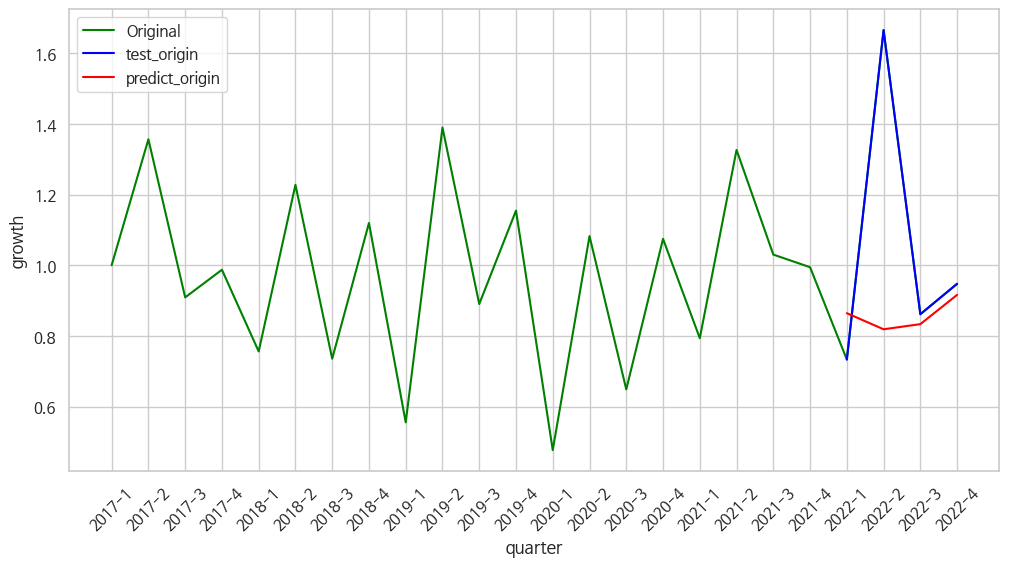

In [40]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [41]:
## error의 요약 통계량
error.describe()

count    4.000000
mean     0.193658
std      0.441770
min     -0.131184
25%     -0.011764
50%      0.029670
75%      0.235091
max      0.846475
dtype: float64

In [42]:
### 23년 1분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 26ms/step
[[0.37838447]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.9264605045318604 


## 23년 1분기 시장성 예측

In [43]:
# 시장성을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 순점포증감률 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_clothes[['성장성', '분기당_매출_금액', '순점포증감률']]
y = sin_clothes.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액    순점포증감률
0   1.000000  14874336524 -2.024291
1   1.356198  20172548016 -0.406504
2   0.908896  18334748922 -2.286902
3   0.987072  18097709389 -1.476793
4   0.755999  13681846686 -1.935484
5   1.227451  16793793365 -0.215517
6   0.735375  12349739322 -0.869565
7   1.119363  13823847354 -0.877193
8   0.555393   7677670701 -2.471910
9   1.389482  10667986159 -1.136364
10  0.890083   9495393370 -2.320186
11  1.154413  10961609488 -0.692841
12  0.476817   5226683301 -2.625298
13  1.082353   5657115497 -0.968523
14  0.648603   3669221952 -1.719902
15  1.074520   3942652100 -2.261307
16  0.793516   3128557349 -1.295337
17  1.326198   4149084973 -1.578947
18  1.029972   4273441350 -1.612903
19  0.994319   4249163196 -1.917808
20  0.733027   3114749463 -2.191781
21  1.665141   5186497830 -0.831025
22  0.861278   4467018071 -0.837989
23  0.947323   4231710213 -0.561798
--------------------------------------------------------------------------------
             시장성
0 

In [44]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [45]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [46]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.32353224 0.07927568 0.74168957]
 [0.39594092 0.06548094 0.85630209]]


In [47]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [48]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4757
Epoch 1: val_loss improved from inf to 0.19748, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.4757 - val_loss: 0.1975
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4588
Epoch 2: val_loss improved from 0.19748 to 0.18964, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.4588 - val_loss: 0.1896
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4425
Epoch 3: val_loss improved from 0.18964 to 0.18202, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.4425 - val_loss: 0.1820
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4268
Epoch 4: val_loss improved from 0.18202 to 0.17463, saving model to stock_model.h5
1/1 [==============================] - 0s 78ms/step - loss: 0.4268 - val_loss: 0.1746
Epoch 5/100
1/1 [=================

In [50]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 878ms/step
[[0.40940785]
 [0.3587194 ]
 [0.40549934]
 [0.5685341 ]]


In [51]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.422023,0.409408
2022-2,0.104810,0.358719
2022-3,0.419720,0.405499
2022-4,0.000000,0.568534


In [52]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 5].values       # 시장성이 sin_clothes의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.422023,0.409408,-4.235434e+06,-4412237.0,1.768026e+05
2022-2,0.104810,0.358719,-8.681121e+06,-5122625.5,-3.558496e+06
2022-3,0.419720,0.405499,-4.267715e+06,-4467014.0,1.992992e+05
2022-4,0.000000,0.568534,-1.015001e+07,-2182115.0,-7.967891e+06


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


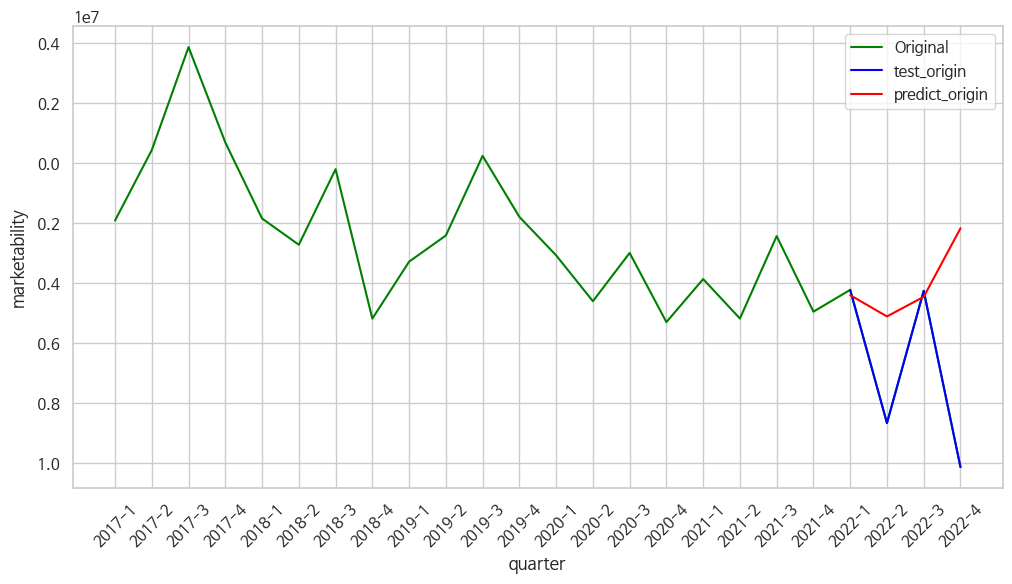

In [53]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [54]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -2.787571e+06
std      3.878958e+06
min     -7.967891e+06
25%     -4.660845e+06
50%     -1.690847e+06
75%      1.824267e+05
max      1.992992e+05
dtype: float64

In [55]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 28ms/step
[[0.48741502]]
--------------------------------------------------------------------------------
예측된 시장성  : -3318982.5 


## 23년 1분기 순점포증감률 예측

In [56]:
# 순점포증감률을 예측하기 위한 지표로는 성장성, 안정성, 총매출, 시장성 선정. => 안정성 제외!

### X / y 데이터 생성
X = sin_clothes[['성장성', '분기당_매출_금액', '시장성']]
y = sin_clothes.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성    분기당_매출_금액           시장성
0   1.000000  14874336524 -1.923574e+06
1   1.356198  20172548016  4.282530e+05
2   0.908896  18334748922  3.864793e+06
3   0.987072  18097709389  6.838851e+05
4   0.755999  13681846686 -1.853374e+06
5   1.227451  16793793365 -2.730931e+06
6   0.735375  12349739322 -2.090695e+05
7   1.119363  13823847354 -5.195801e+06
8   0.555393   7677670701 -3.294589e+06
9   1.389482  10667986159 -2.422348e+06
10  0.890083   9495393370  2.349194e+05
11  1.154413  10961609488 -1.800125e+06
12  0.476817   5226683301 -3.083545e+06
13  1.082353   5657115497 -4.613689e+06
14  0.648603   3669221952 -3.003963e+06
15  1.074520   3942652100 -5.311729e+06
16  0.793516   3128557349 -3.875800e+06
17  1.326198   4149084973 -5.192278e+06
18  1.029972   4273441350 -2.441964e+06
19  0.994319   4249163196 -4.963014e+06
20  0.733027   3114749463 -4.235434e+06
21  1.665141   5186497830 -8.681121e+06
22  0.861278   4467018071 -4.267715e+06
23  0.947323   4231710213 -1.015001e+07


In [57]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (24, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (24, 1)


In [58]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')

X_data 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (22, 1)


In [59]:
### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

[[0.32353224 0.07927568 0.41971998]
 [0.39594092 0.06548094 0.        ]]


In [60]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (18, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (18, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (18, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [61]:
# 필요한 라이브러리 임폴트
import tensorflow as tf
import random

# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3799
Epoch 1: val_loss improved from inf to 0.17606, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.3799 - val_loss: 0.1761
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3657
Epoch 2: val_loss improved from 0.17606 to 0.16918, saving model to stock_model.h5
1/1 [==============================] - 0s 93ms/step - loss: 0.3657 - val_loss: 0.1692
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3521
Epoch 3: val_loss improved from 0.16918 to 0.16258, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.3521 - val_loss: 0.1626
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3390
Epoch 4: val_loss improved from 0.16258 to 0.15623, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.3390 - val_loss: 0.1562
Epoch 5/100
1/1 [=================

In [63]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 781ms/step
[[0.34656537]
 [0.3105688 ]
 [0.30648705]
 [0.33101445]]


In [64]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-1,0.179899,0.346565
2022-2,0.744579,0.310569
2022-3,0.741690,0.306487
2022-4,0.856302,0.331014


In [65]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_clothes의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-1,0.179899,0.346565,-2.191781,-1.790152,-0.401629
2022-2,0.744579,0.310569,-0.831025,-1.876896,1.045871
2022-3,0.741690,0.306487,-0.837989,-1.886732,1.048743
2022-4,0.856302,0.331014,-0.561798,-1.827626,1.265828


### 결과

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


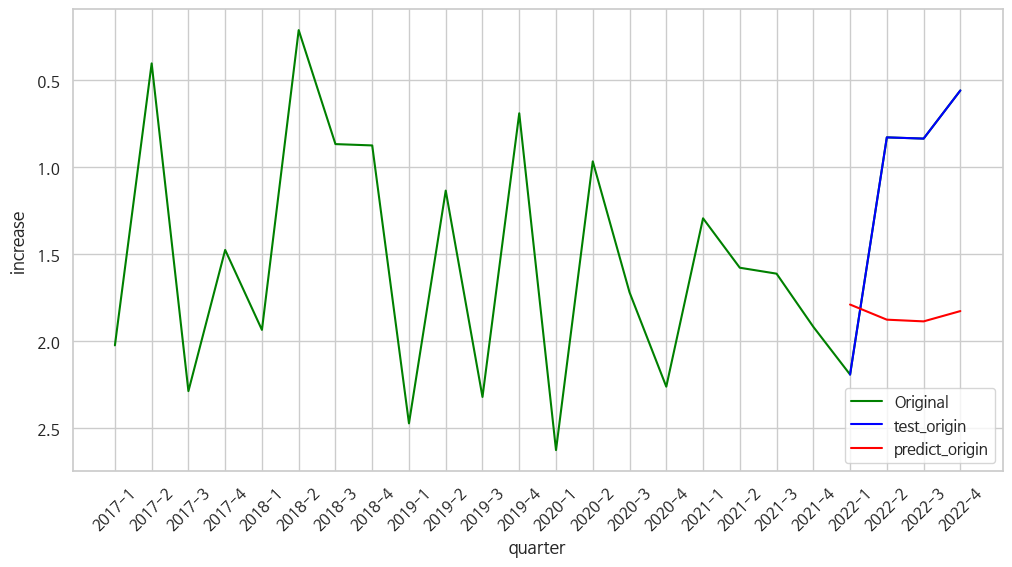

In [66]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [67]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.739703
std      0.767830
min     -0.401629
25%      0.683996
50%      1.047307
75%      1.103014
max      1.265828
dtype: float64

In [68]:
### 23년 1분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 24ms/step
[[0.2877613]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.9318565130233765 


## 원본 데이터에 예측값 추가하기

In [69]:
print(sales)
print(growth)
print(marketability)
print(increase)

4509228500.0
0.9264605
-3318982.5
-1.9318565


In [70]:
sin_clothes.loc[24] = ['2023-1', '일반의류', sales, growth, increase, marketability]

<ipython-input-70-c91bbcf9801c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_clothes.loc[24] = ['2023-1', '일반의류', sales, growth, increase, marketability]


In [71]:
sin_clothes

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반의류,1.487434e+10,1.000000,-2.024291,-1.923574e+06
1,2017-2,일반의류,2.017255e+10,1.356198,-0.406504,4.282530e+05
2,2017-3,일반의류,1.833475e+10,0.908896,-2.286902,3.864793e+06
3,2017-4,일반의류,1.809771e+10,0.987072,-1.476793,6.838851e+05
4,2018-1,일반의류,1.368185e+10,0.755999,-1.935484,-1.853374e+06
5,2018-2,일반의류,1.679379e+10,1.227451,-0.215517,-2.730931e+06
6,2018-3,일반의류,1.234974e+10,0.735375,-0.869565,-2.090695e+05
7,2018-4,일반의류,1.382385e+10,1.119363,-0.877193,-5.195801e+06
8,2019-1,일반의류,7.677671e+09,0.555393,-2.471910,-3.294589e+06
9,2019-2,일반의류,1.066799e+10,1.389482,-1.136364,-2.422348e+06


## 23년 2분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [72]:
################ 매출 ####################

# 총 매출액을 예측하기 위한 지표로는 성장성, 시장성, 순점포증감률 선정.

### X / y 데이터 생성
X = sin_clothes[['성장성', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -1.923574e+06 -2.024291
1   1.356198  4.282530e+05 -0.406504
2   0.908896  3.864793e+06 -2.286902
3   0.987072  6.838851e+05 -1.476793
4   0.755999 -1.853374e+06 -1.935484
5   1.227451 -2.730931e+06 -0.215517
6   0.735375 -2.090695e+05 -0.869565
7   1.119363 -5.195801e+06 -0.877193
8   0.555393 -3.294589e+06 -2.471910
9   1.389482 -2.422348e+06 -1.136364
10  0.890083  2.349194e+05 -2.320186
11  1.154413 -1.800125e+06 -0.692841
12  0.476817 -3.083545e+06 -2.625298
13  1.082353 -4.613689e+06 -0.968523
14  0.648603 -3.003963e+06 -1.719902
15  1.074520 -5.311729e+06 -2.261307
16  0.793516 -3.875800e+06 -1.295337
17  1.326198 -5.192278e+06 -1.578947
18  1.029972 -2.441964e+06 -1.612903
19  0.994319 -4.963014e+06 -1.917808
20  0.733027 -4.235434e+06 -2.191781
21  1.665141 -8.681121e+06 -0.831025
22  0.861278 -4.267715e+06 -0.837989
23  0.947323 -1.015001e+07 -0.561798
24  0.926461 -3.318982e+06 -1.931857
--------------------------------------

In [73]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [74]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.39594092 0.         0.85630209]
 [0.37838445 0.48741501 0.28776133]]


In [75]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [76]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             17408     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3956
Epoch 1: val_loss improved from inf to 0.00662, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3956 - val_loss: 0.0066
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3808
Epoch 2: val_loss improved from 0.00662 to 0.00524, saving model to stock_model.h5
1/1 [==============================] - 0s 125ms/step - loss: 0.3808 - val_loss: 0.0052
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3666
Epoch 3: val_loss improved from 0.00524 to 0.00411, saving model to stock_model.h5
1/1 [==============================] - 0s 116ms/step - loss: 0.3666 - val_loss: 0.0041
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3529
Epoch 4: val_loss improved from 0.00411 to 0.00321, saving model to stock_model.h5
1/1 [==============================] - 0s 116ms/step - loss: 0.3529 - val_loss: 0.0032
Epoch 5/100
1/1 [==============

In [78]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 800ms/step
[[0.05416854]
 [0.06156801]
 [0.07619946]
 [0.07009986]]


In [79]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.121455,0.054169
2022-3,0.079276,0.061568
2022-4,0.065481,0.076199
2023-1,0.081750,0.070100


In [80]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_clothes의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.121455,0.054169,5.186498e+09,4.038746e+09,1.147752e+09
2022-3,0.079276,0.061568,4.467018e+09,4.164964e+09,3.020540e+08
2022-4,0.065481,0.076199,4.231710e+09,4.414544e+09,-1.828342e+08
2023-1,0.081750,0.070100,4.509229e+09,4.310499e+09,1.987297e+08


In [81]:
df_test = df_test.reset_index()

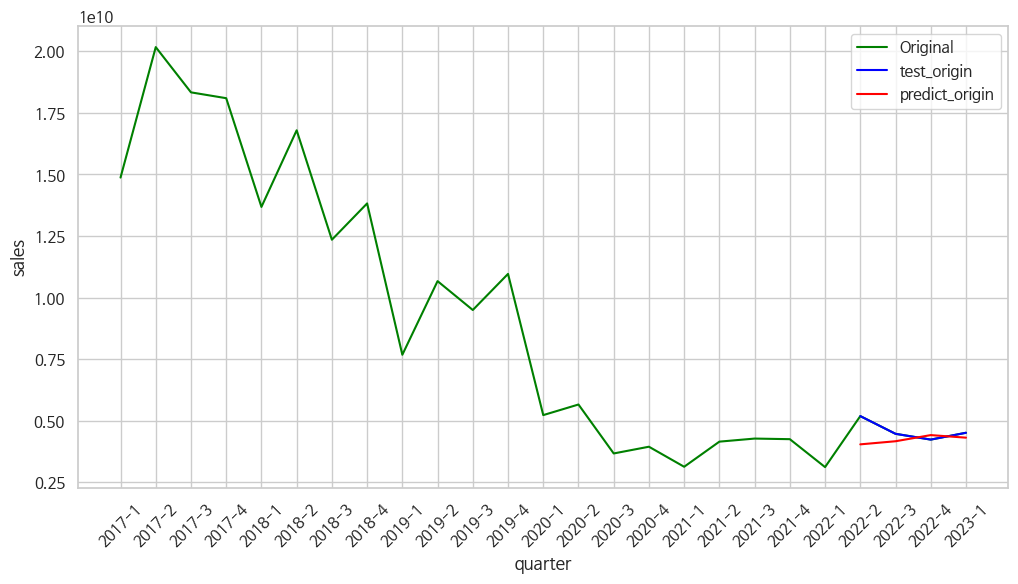

In [82]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [83]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     3.664254e+08
std      5.610773e+08
min     -1.828342e+08
25%      1.033388e+08
50%      2.503919e+08
75%      5.134785e+08
max      1.147752e+09
dtype: float64

In [84]:
### 23년 2분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 26ms/step
[[0.06514969]]
--------------------------------------------------------------------------------
예측된 매출  : 4226060032.0 


### 성장성

In [85]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.487434e+10 -1.923574e+06 -2.024291
1   2.017255e+10  4.282530e+05 -0.406504
2   1.833475e+10  3.864793e+06 -2.286902
3   1.809771e+10  6.838851e+05 -1.476793
4   1.368185e+10 -1.853374e+06 -1.935484
5   1.679379e+10 -2.730931e+06 -0.215517
6   1.234974e+10 -2.090695e+05 -0.869565
7   1.382385e+10 -5.195801e+06 -0.877193
8   7.677671e+09 -3.294589e+06 -2.471910
9   1.066799e+10 -2.422348e+06 -1.136364
10  9.495393e+09  2.349194e+05 -2.320186
11  1.096161e+10 -1.800125e+06 -0.692841
12  5.226683e+09 -3.083545e+06 -2.625298
13  5.657115e+09 -4.613689e+06 -0.968523
14  3.669222e+09 -3.003963e+06 -1.719902
15  3.942652e+09 -5.311729e+06 -2.261307
16  3.128557e+09 -3.875800e+06 -1.295337
17  4.149085e+09 -5.192278e+06 -1.578947
18  4.273441e+09 -2.441964e+06 -1.612903
19  4.249163e+09 -4.963014e+06 -1.917808
20  3.114749e+09 -4.235434e+06 -2.191781
21  5.186498e+09 -8.681121e+06 -0.831025
22  4.467018e+09 -4.267715e+06 -0.837989
23  4.231710e+09

In [86]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [87]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.06548094 0.         0.85630209]
 [0.08175024 0.48741501 0.28776133]]


In [88]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [89]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [90]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2228
Epoch 1: val_loss improved from inf to 0.20718, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2228 - val_loss: 0.2072
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2119
Epoch 2: val_loss improved from 0.20718 to 0.19920, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.2119 - val_loss: 0.1992
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2015
Epoch 3: val_loss improved from 0.19920 to 0.19150, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.2015 - val_loss: 0.1915
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1916
Epoch 4: val_loss improved from 0.19150 to 0.18407, saving model to stock_model.h5
1/1 [==============================] - 0s 92ms/step - loss: 0.1916 - val_loss: 0.1841
Epoch 5/100
1/1 [=================

In [91]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 803ms/step
[[0.26927158]
 [0.2818153 ]
 [0.3497294 ]
 [0.35752252]]


In [92]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,1.000000,0.269272
2022-3,0.323532,0.281815
2022-4,0.395941,0.349729
2023-1,0.378384,0.357523


In [93]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 3].values       # 성장성이 sin_clothes의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,1.000000,0.269272,1.665141,0.796799,0.868342
2022-3,0.323532,0.281815,0.861278,0.811705,0.049573
2022-4,0.395941,0.349729,0.947323,0.892409,0.054914
2023-1,0.378384,0.357523,0.926461,0.901670,0.024791


In [94]:
df_test = df_test.reset_index()

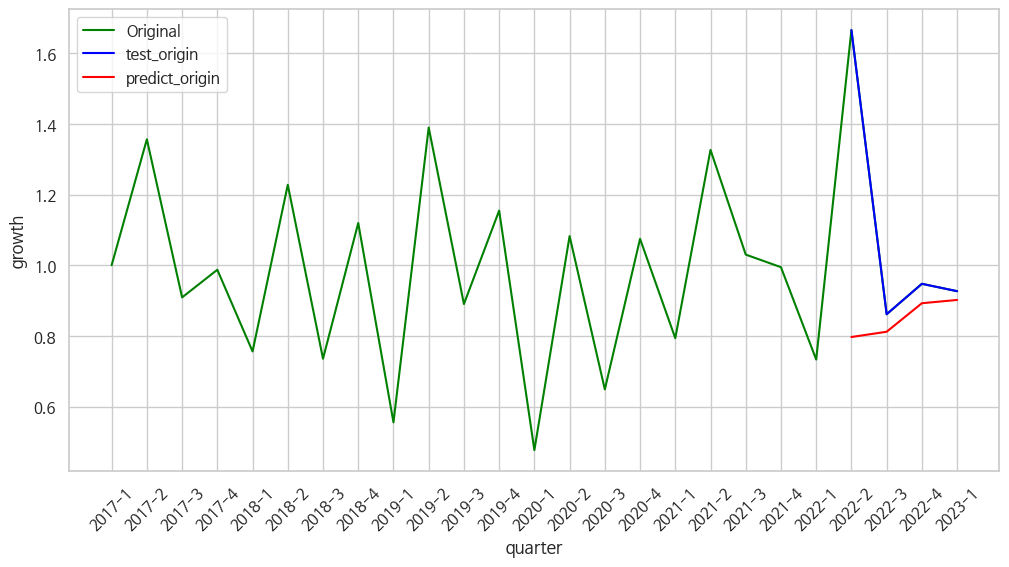

In [95]:
### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [96]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.249405
std      0.412833
min      0.024791
25%      0.043378
50%      0.052244
75%      0.258271
max      0.868342
dtype: float64

In [97]:
### 23년 2분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 23ms/step
[[0.32431298]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8622060418128967 


### 시장성

In [98]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_clothes.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.487434e+10  1.000000 -2.024291
1   2.017255e+10  1.356198 -0.406504
2   1.833475e+10  0.908896 -2.286902
3   1.809771e+10  0.987072 -1.476793
4   1.368185e+10  0.755999 -1.935484
5   1.679379e+10  1.227451 -0.215517
6   1.234974e+10  0.735375 -0.869565
7   1.382385e+10  1.119363 -0.877193
8   7.677671e+09  0.555393 -2.471910
9   1.066799e+10  1.389482 -1.136364
10  9.495393e+09  0.890083 -2.320186
11  1.096161e+10  1.154413 -0.692841
12  5.226683e+09  0.476817 -2.625298
13  5.657115e+09  1.082353 -0.968523
14  3.669222e+09  0.648603 -1.719902
15  3.942652e+09  1.074520 -2.261307
16  3.128557e+09  0.793516 -1.295337
17  4.149085e+09  1.326198 -1.578947
18  4.273441e+09  1.029972 -1.612903
19  4.249163e+09  0.994319 -1.917808
20  3.114749e+09  0.733027 -2.191781
21  5.186498e+09  1.665141 -0.831025
22  4.467018e+09  0.861278 -0.837989
23  4.231710e+09  0.947323 -0.561798
24  4.509229e+09  0.926461 -1.931857
--------------------------------------

In [99]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [100]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.06548094 0.39594092 0.85630209]
 [0.08175024 0.37838445 0.28776133]]


In [101]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [102]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [103]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4490
Epoch 1: val_loss improved from inf to 0.19439, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4490 - val_loss: 0.1944
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4329
Epoch 2: val_loss improved from 0.19439 to 0.18649, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.4329 - val_loss: 0.1865
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4174
Epoch 3: val_loss improved from 0.18649 to 0.17887, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.4174 - val_loss: 0.1789
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.4023
Epoch 4: val_loss improved from 0.17887 to 0.17151, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.4023 - val_loss: 0.1715
Epoch 5/100
1/1 [=================

In [104]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.353646  ]
 [0.39508495]
 [0.5532169 ]
 [0.4918458 ]]


In [105]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.104810,0.353646
2022-3,0.419720,0.395085
2022-4,0.000000,0.553217
2023-1,0.487415,0.491846


In [106]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 5].values       # 시장성이 sin_clothes의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.104810,0.353646,-8.681121e+06,-5193728.0,-3.487393e+06
2022-3,0.419720,0.395085,-4.267715e+06,-4612970.0,3.452552e+05
2022-4,0.000000,0.553217,-1.015001e+07,-2396782.5,-7.753224e+06
2023-1,0.487415,0.491846,-3.318982e+06,-3256886.0,-6.209650e+04


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


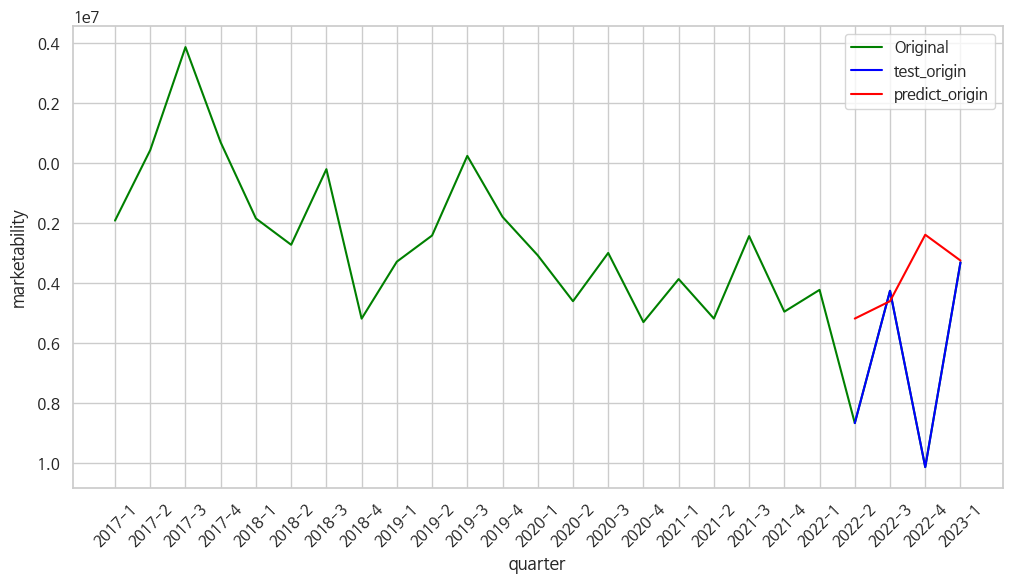

In [107]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [108]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -2.739365e+06
std      3.758589e+06
min     -7.753224e+06
25%     -4.553851e+06
50%     -1.774745e+06
75%      3.974142e+04
max      3.452552e+05
dtype: float64

In [109]:
### 23년 2분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 33ms/step
[[0.46665698]]
--------------------------------------------------------------------------------
예측된 시장성  : -3609902.0 


### 순점포증감률

In [110]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '시장성']]
y = sin_clothes.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.487434e+10  1.000000 -1.923574e+06
1   2.017255e+10  1.356198  4.282530e+05
2   1.833475e+10  0.908896  3.864793e+06
3   1.809771e+10  0.987072  6.838851e+05
4   1.368185e+10  0.755999 -1.853374e+06
5   1.679379e+10  1.227451 -2.730931e+06
6   1.234974e+10  0.735375 -2.090695e+05
7   1.382385e+10  1.119363 -5.195801e+06
8   7.677671e+09  0.555393 -3.294589e+06
9   1.066799e+10  1.389482 -2.422348e+06
10  9.495393e+09  0.890083  2.349194e+05
11  1.096161e+10  1.154413 -1.800125e+06
12  5.226683e+09  0.476817 -3.083545e+06
13  5.657115e+09  1.082353 -4.613689e+06
14  3.669222e+09  0.648603 -3.003963e+06
15  3.942652e+09  1.074520 -5.311729e+06
16  3.128557e+09  0.793516 -3.875800e+06
17  4.149085e+09  1.326198 -5.192278e+06
18  4.273441e+09  1.029972 -2.441964e+06
19  4.249163e+09  0.994319 -4.963014e+06
20  3.114749e+09  0.733027 -4.235434e+06
21  5.186498e+09  1.665141 -8.681121e+06
22  4.467018e+09  0.861278 -4.267715e+06
23  4.231710e+09

In [111]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (25, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (25, 1)


In [112]:
### 시계열 분석에 적합한 데이터 생성

# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (23, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (23, 1)
[[0.06548094 0.39594092 0.        ]
 [0.08175024 0.37838445 0.48741501]]


In [113]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (19, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (19, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (19, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [114]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [115]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3384
Epoch 1: val_loss improved from inf to 0.18676, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3384 - val_loss: 0.1868
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3258
Epoch 2: val_loss improved from 0.18676 to 0.17923, saving model to stock_model.h5
1/1 [==============================] - 0s 91ms/step - loss: 0.3258 - val_loss: 0.1792
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3137
Epoch 3: val_loss improved from 0.17923 to 0.17195, saving model to stock_model.h5
1/1 [==============================] - 0s 96ms/step - loss: 0.3137 - val_loss: 0.1719
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3021
Epoch 4: val_loss improved from 0.17195 to 0.16489, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.3021 - val_loss: 0.1649
Epoch 5/100
1/1 [=================

In [116]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 1s/step
[[0.33672255]
 [0.32901695]
 [0.3568981 ]
 [0.31493312]]


In [117]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-2,0.744579,0.336723
2022-3,0.741690,0.329017
2022-4,0.856302,0.356898
2023-1,0.287761,0.314933


In [118]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_clothes의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-2,0.744579,0.336723,-0.831025,-1.813871,0.982846
2022-3,0.741690,0.329017,-0.837989,-1.832439,0.994451
2022-4,0.856302,0.356898,-0.561798,-1.765252,1.203454
2023-1,0.287761,0.314933,-1.931857,-1.866379,-0.065478


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


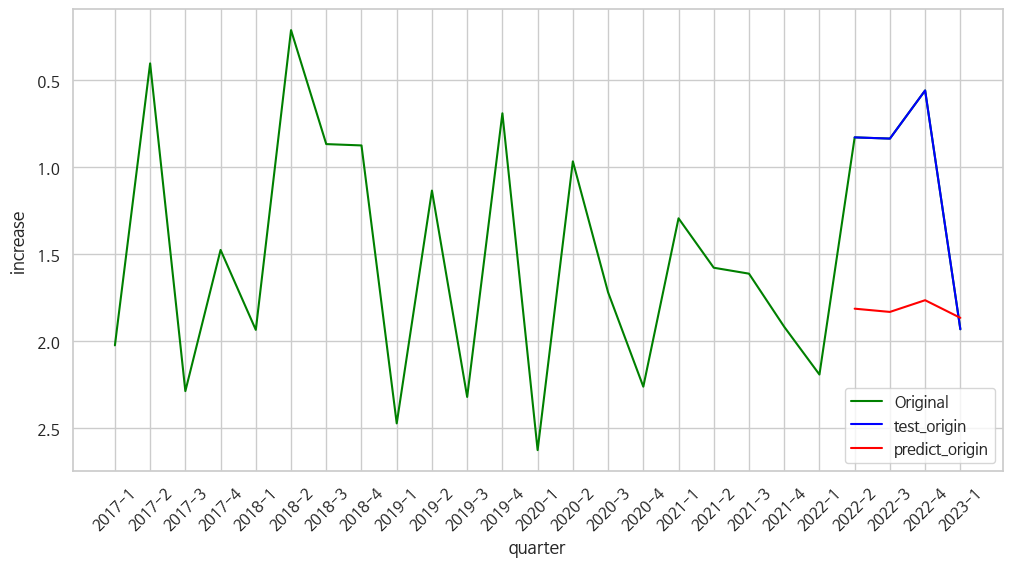

In [119]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [120]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.778818
std      0.571920
min     -0.065478
25%      0.720765
50%      0.988648
75%      1.046702
max      1.203454
dtype: float64

In [121]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 34ms/step
[[0.2956286]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.9128981828689575 


### 추가


In [122]:
sin_clothes.loc[25] = ['2023-2', '일반의류', sales, growth, increase, marketability]

<ipython-input-122-fd37a737da49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_clothes.loc[25] = ['2023-2', '일반의류', sales, growth, increase, marketability]


In [123]:
sin_clothes

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반의류,1.487434e+10,1.000000,-2.024291,-1.923574e+06
1,2017-2,일반의류,2.017255e+10,1.356198,-0.406504,4.282530e+05
2,2017-3,일반의류,1.833475e+10,0.908896,-2.286902,3.864793e+06
3,2017-4,일반의류,1.809771e+10,0.987072,-1.476793,6.838851e+05
4,2018-1,일반의류,1.368185e+10,0.755999,-1.935484,-1.853374e+06
5,2018-2,일반의류,1.679379e+10,1.227451,-0.215517,-2.730931e+06
6,2018-3,일반의류,1.234974e+10,0.735375,-0.869565,-2.090695e+05
7,2018-4,일반의류,1.382385e+10,1.119363,-0.877193,-5.195801e+06
8,2019-1,일반의류,7.677671e+09,0.555393,-2.471910,-3.294589e+06
9,2019-2,일반의류,1.066799e+10,1.389482,-1.136364,-2.422348e+06


## 23년 3분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본 데이터에 추가

### 매출

In [124]:
################ 매출 ####################

### X / y 데이터 생성
X = sin_clothes[['성장성', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -1.923574e+06 -2.024291
1   1.356198  4.282530e+05 -0.406504
2   0.908896  3.864793e+06 -2.286902
3   0.987072  6.838851e+05 -1.476793
4   0.755999 -1.853374e+06 -1.935484
5   1.227451 -2.730931e+06 -0.215517
6   0.735375 -2.090695e+05 -0.869565
7   1.119363 -5.195801e+06 -0.877193
8   0.555393 -3.294589e+06 -2.471910
9   1.389482 -2.422348e+06 -1.136364
10  0.890083  2.349194e+05 -2.320186
11  1.154413 -1.800125e+06 -0.692841
12  0.476817 -3.083545e+06 -2.625298
13  1.082353 -4.613689e+06 -0.968523
14  0.648603 -3.003963e+06 -1.719902
15  1.074520 -5.311729e+06 -2.261307
16  0.793516 -3.875800e+06 -1.295337
17  1.326198 -5.192278e+06 -1.578947
18  1.029972 -2.441964e+06 -1.612903
19  0.994319 -4.963014e+06 -1.917808
20  0.733027 -4.235434e+06 -2.191781
21  1.665141 -8.681121e+06 -0.831025
22  0.861278 -4.267715e+06 -0.837989
23  0.947323 -1.015001e+07 -0.561798
24  0.926461 -3.318982e+06 -1.931857
25  0.862206 -3.609902e+06 -1.912898
-

In [125]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [126]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.37838445 0.48741501 0.28776133]
 [0.32431295 0.46665699 0.29562857]]


In [127]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [128]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [129]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3653
Epoch 1: val_loss improved from inf to 0.00533, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3653 - val_loss: 0.0053
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3514
Epoch 2: val_loss improved from 0.00533 to 0.00411, saving model to stock_model.h5
1/1 [==============================] - 0s 107ms/step - loss: 0.3514 - val_loss: 0.0041
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3381
Epoch 3: val_loss improved from 0.00411 to 0.00313, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.3381 - val_loss: 0.0031
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3252
Epoch 4: val_loss improved from 0.00313 to 0.00237, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.3252 - val_loss: 0.0024
Epoch 5/100
1/1 [================

In [130]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 819ms/step
[[0.05139567]
 [0.06388838]
 [0.05876243]
 [0.05472355]]


In [131]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.079276,0.051396
2022-4,0.065481,0.063888
2023-1,0.081750,0.058762
2023-2,0.065150,0.054724


In [132]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_clothes의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.079276,0.051396,4.467018e+09,3.991447e+09,475571543.0
2022-4,0.065481,0.063888,4.231710e+09,4.204545e+09,27165701.0
2023-1,0.081750,0.058762,4.509229e+09,4.117107e+09,392121344.0
2023-2,0.065150,0.054724,4.226060e+09,4.048213e+09,177847296.0


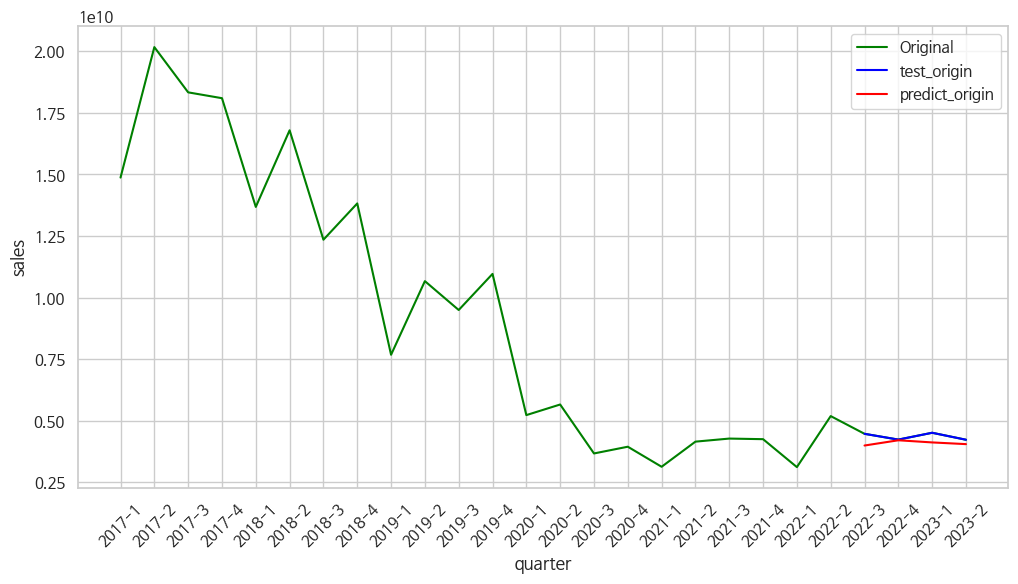

In [133]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [134]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     2.681765e+08
std      2.038141e+08
min      2.716570e+07
25%      1.401769e+08
50%      2.849843e+08
75%      4.129839e+08
max      4.755715e+08
dtype: float64

In [135]:
### 23년 3분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 22ms/step
[[0.04544152]]
--------------------------------------------------------------------------------
예측된 매출  : 3889881856.0 


### 성장성

In [136]:
X = sin_clothes[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.487434e+10 -1.923574e+06 -2.024291
1   2.017255e+10  4.282530e+05 -0.406504
2   1.833475e+10  3.864793e+06 -2.286902
3   1.809771e+10  6.838851e+05 -1.476793
4   1.368185e+10 -1.853374e+06 -1.935484
5   1.679379e+10 -2.730931e+06 -0.215517
6   1.234974e+10 -2.090695e+05 -0.869565
7   1.382385e+10 -5.195801e+06 -0.877193
8   7.677671e+09 -3.294589e+06 -2.471910
9   1.066799e+10 -2.422348e+06 -1.136364
10  9.495393e+09  2.349194e+05 -2.320186
11  1.096161e+10 -1.800125e+06 -0.692841
12  5.226683e+09 -3.083545e+06 -2.625298
13  5.657115e+09 -4.613689e+06 -0.968523
14  3.669222e+09 -3.003963e+06 -1.719902
15  3.942652e+09 -5.311729e+06 -2.261307
16  3.128557e+09 -3.875800e+06 -1.295337
17  4.149085e+09 -5.192278e+06 -1.578947
18  4.273441e+09 -2.441964e+06 -1.612903
19  4.249163e+09 -4.963014e+06 -1.917808
20  3.114749e+09 -4.235434e+06 -2.191781
21  5.186498e+09 -8.681121e+06 -0.831025
22  4.467018e+09 -4.267715e+06 -0.837989
23  4.231710e+09

In [137]:
### Normalization 진행

'''
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalization한다
# MinMaxScaler : (X - MIN) / (MAX - MIN)
'''

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [138]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.08175024 0.48741501 0.28776133]
 [0.06514971 0.46665699 0.29562857]]


In [139]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [140]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [141]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2285
Epoch 1: val_loss improved from inf to 0.30000, saving model to stock_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.2285 - val_loss: 0.3000
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2175
Epoch 2: val_loss improved from 0.30000 to 0.29143, saving model to stock_model.h5
1/1 [==============================] - 0s 89ms/step - loss: 0.2175 - val_loss: 0.2914
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2069
Epoch 3: val_loss improved from 0.29143 to 0.28313, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.2069 - val_loss: 0.2831
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1969
Epoch 4: val_loss improved from 0.28313 to 0.27510, saving model to stock_model.h5
1/1 [==============================] - 0s 89ms/step - loss: 0.1969 - val_loss: 0.2751
Epoch 5/100
1/1 [=================

In [142]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 807ms/step
[[0.2931066 ]
 [0.3641187 ]
 [0.37269592]
 [0.33805692]]


In [143]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.323532,0.293107
2022-4,0.395941,0.364119
2023-1,0.378384,0.372696
2023-2,0.324313,0.338057


In [144]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 3].values       # 성장성이 sin_clothes의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.323532,0.293107,0.861278,0.825123,0.036156
2022-4,0.395941,0.364119,0.947323,0.909508,0.037815
2023-1,0.378384,0.372696,0.926461,0.919701,0.006760
2023-2,0.324313,0.338057,0.862206,0.878538,-0.016332


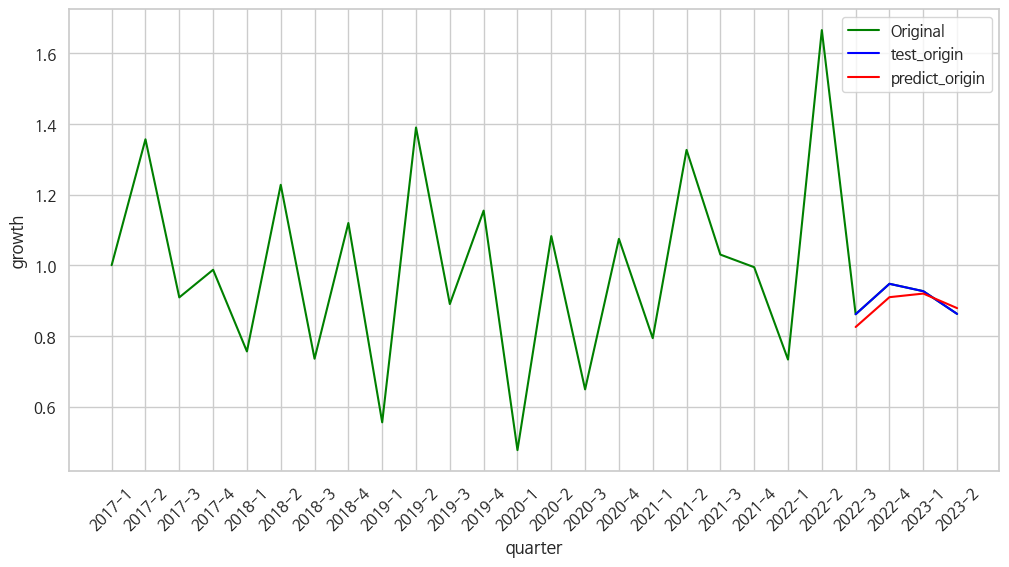

In [145]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [146]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.016100
std      0.025903
min     -0.016332
25%      0.000987
50%      0.021458
75%      0.036570
max      0.037815
dtype: float64

In [147]:
### 23년 3분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 25ms/step
[[0.3028024]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8366445302963257 


### 시장성

In [148]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_clothes.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.487434e+10  1.000000 -2.024291
1   2.017255e+10  1.356198 -0.406504
2   1.833475e+10  0.908896 -2.286902
3   1.809771e+10  0.987072 -1.476793
4   1.368185e+10  0.755999 -1.935484
5   1.679379e+10  1.227451 -0.215517
6   1.234974e+10  0.735375 -0.869565
7   1.382385e+10  1.119363 -0.877193
8   7.677671e+09  0.555393 -2.471910
9   1.066799e+10  1.389482 -1.136364
10  9.495393e+09  0.890083 -2.320186
11  1.096161e+10  1.154413 -0.692841
12  5.226683e+09  0.476817 -2.625298
13  5.657115e+09  1.082353 -0.968523
14  3.669222e+09  0.648603 -1.719902
15  3.942652e+09  1.074520 -2.261307
16  3.128557e+09  0.793516 -1.295337
17  4.149085e+09  1.326198 -1.578947
18  4.273441e+09  1.029972 -1.612903
19  4.249163e+09  0.994319 -1.917808
20  3.114749e+09  0.733027 -2.191781
21  5.186498e+09  1.665141 -0.831025
22  4.467018e+09  0.861278 -0.837989
23  4.231710e+09  0.947323 -0.561798
24  4.509229e+09  0.926461 -1.931857
25  4.226060e+09  0.862206 -1.912898
-

In [149]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [150]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.08175024 0.37838445 0.28776133]
 [0.06514971 0.32431295 0.29562857]]


In [151]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [152]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [153]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4260
Epoch 1: val_loss improved from inf to 0.17545, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4260 - val_loss: 0.1755
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4105
Epoch 2: val_loss improved from 0.17545 to 0.16837, saving model to stock_model.h5
1/1 [==============================] - 0s 109ms/step - loss: 0.4105 - val_loss: 0.1684
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3956
Epoch 3: val_loss improved from 0.16837 to 0.16154, saving model to stock_model.h5
1/1 [==============================] - 0s 145ms/step - loss: 0.3956 - val_loss: 0.1615
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3811
Epoch 4: val_loss improved from 0.16154 to 0.15495, saving model to stock_model.h5
1/1 [==============================] - 0s 112ms/step - loss: 0.3811 - val_loss: 0.1549
Epoch 5/100
1/1 [==============

In [154]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 791ms/step
[[0.39405143]
 [0.5525024 ]
 [0.49114192]
 [0.4659672 ]]


In [155]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.419720,0.394051
2022-4,0.000000,0.552502
2023-1,0.487415,0.491142
2023-2,0.466657,0.465967


In [156]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 5].values       # 시장성이 sin_clothes의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.419720,0.394051,-4.267715e+06,-4627454.50,3.597397e+05
2022-4,0.000000,0.552502,-1.015001e+07,-2406795.75,-7.743210e+06
2023-1,0.487415,0.491142,-3.318982e+06,-3266750.75,-5.223175e+04
2023-2,0.466657,0.465967,-3.609902e+06,-3619569.00,9.667000e+03


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


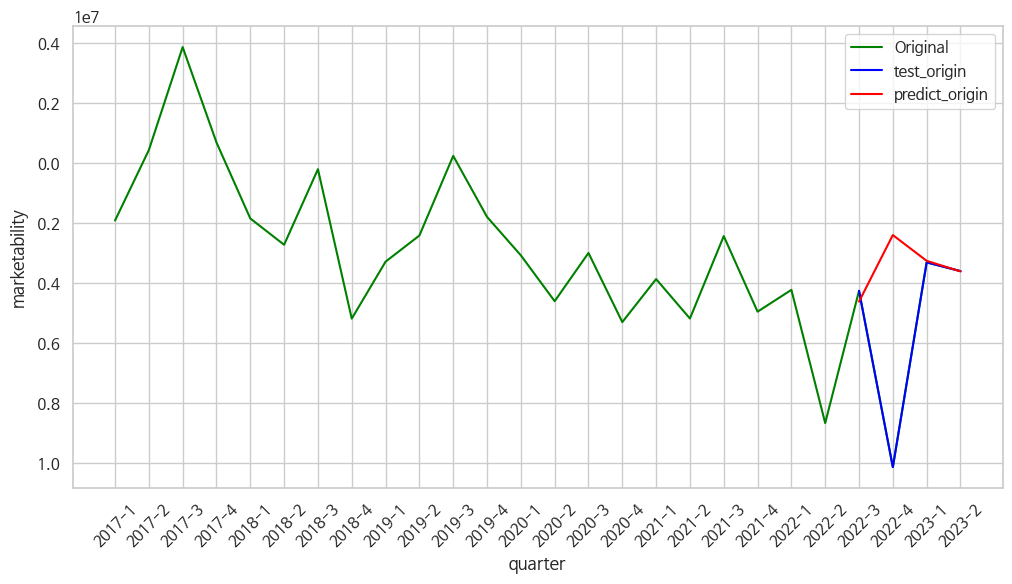

In [157]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [158]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -1.856509e+06
std      3.928657e+06
min     -7.743210e+06
25%     -1.974976e+06
50%     -2.128238e+04
75%      9.718517e+04
max      3.597397e+05
dtype: float64

In [159]:
### 23년 3분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 22ms/step
[[0.369078]]
--------------------------------------------------------------------------------
예측된 시장성  : -4977452.0 


### 순점포증감률

In [160]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '시장성']]
y = sin_clothes.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.487434e+10  1.000000 -1.923574e+06
1   2.017255e+10  1.356198  4.282530e+05
2   1.833475e+10  0.908896  3.864793e+06
3   1.809771e+10  0.987072  6.838851e+05
4   1.368185e+10  0.755999 -1.853374e+06
5   1.679379e+10  1.227451 -2.730931e+06
6   1.234974e+10  0.735375 -2.090695e+05
7   1.382385e+10  1.119363 -5.195801e+06
8   7.677671e+09  0.555393 -3.294589e+06
9   1.066799e+10  1.389482 -2.422348e+06
10  9.495393e+09  0.890083  2.349194e+05
11  1.096161e+10  1.154413 -1.800125e+06
12  5.226683e+09  0.476817 -3.083545e+06
13  5.657115e+09  1.082353 -4.613689e+06
14  3.669222e+09  0.648603 -3.003963e+06
15  3.942652e+09  1.074520 -5.311729e+06
16  3.128557e+09  0.793516 -3.875800e+06
17  4.149085e+09  1.326198 -5.192278e+06
18  4.273441e+09  1.029972 -2.441964e+06
19  4.249163e+09  0.994319 -4.963014e+06
20  3.114749e+09  0.733027 -4.235434e+06
21  5.186498e+09  1.665141 -8.681121e+06
22  4.467018e+09  0.861278 -4.267715e+06
23  4.231710e+09

In [161]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (26, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (26, 1)


In [162]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (24, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (24, 1)
[[0.08175024 0.37838445 0.48741501]
 [0.06514971 0.32431295 0.46665699]]


In [163]:
## 학습용 / 평가용 데이터로 분할

# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (20, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (20, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (20, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [164]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [165]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3521
Epoch 1: val_loss improved from inf to 0.19692, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3521 - val_loss: 0.1969
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3392
Epoch 2: val_loss improved from 0.19692 to 0.18962, saving model to stock_model.h5
1/1 [==============================] - 0s 125ms/step - loss: 0.3392 - val_loss: 0.1896
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3269
Epoch 3: val_loss improved from 0.18962 to 0.18253, saving model to stock_model.h5
1/1 [==============================] - 0s 112ms/step - loss: 0.3269 - val_loss: 0.1825
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3150
Epoch 4: val_loss improved from 0.18253 to 0.17565, saving model to stock_model.h5
1/1 [==============================] - 0s 131ms/step - loss: 0.3150 - val_loss: 0.1756
Epoch 5/100
1/1 [==============

In [166]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 794ms/step
[[0.3472035 ]
 [0.3765945 ]
 [0.3319121 ]
 [0.31076297]]


In [167]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-3,0.741690,0.347203
2022-4,0.856302,0.376595
2023-1,0.287761,0.331912
2023-2,0.295629,0.310763


In [168]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_clothes의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-3,0.741690,0.347203,-0.837989,-1.788614,0.950625
2022-4,0.856302,0.376595,-0.561798,-1.717788,1.155990
2023-1,0.287761,0.331912,-1.931857,-1.825463,-0.106394
2023-2,0.295629,0.310763,-1.912898,-1.876428,-0.036471


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


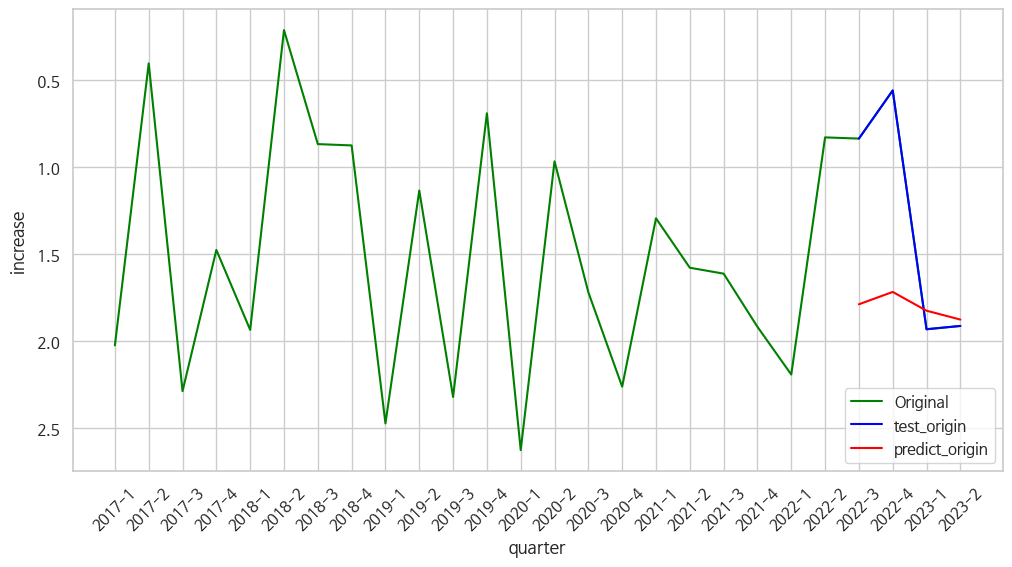

In [169]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [170]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.490938
std      0.655381
min     -0.106394
25%     -0.053951
50%      0.457077
75%      1.001966
max      1.155990
dtype: float64

In [171]:
### 23년 3분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 23ms/step
[[0.38450584]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.6987234354019165 


### 추가

In [172]:
sin_clothes.loc[26] = ['2023-3', '일반의류', sales, growth, increase, marketability]

<ipython-input-172-647f034988d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_clothes.loc[26] = ['2023-3', '일반의류', sales, growth, increase, marketability]


In [173]:
sin_clothes

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반의류,1.487434e+10,1.000000,-2.024291,-1.923574e+06
1,2017-2,일반의류,2.017255e+10,1.356198,-0.406504,4.282530e+05
2,2017-3,일반의류,1.833475e+10,0.908896,-2.286902,3.864793e+06
3,2017-4,일반의류,1.809771e+10,0.987072,-1.476793,6.838851e+05
4,2018-1,일반의류,1.368185e+10,0.755999,-1.935484,-1.853374e+06
5,2018-2,일반의류,1.679379e+10,1.227451,-0.215517,-2.730931e+06
6,2018-3,일반의류,1.234974e+10,0.735375,-0.869565,-2.090695e+05
7,2018-4,일반의류,1.382385e+10,1.119363,-0.877193,-5.195801e+06
8,2019-1,일반의류,7.677671e+09,0.555393,-2.471910,-3.294589e+06
9,2019-2,일반의류,1.066799e+10,1.389482,-1.136364,-2.422348e+06


## 23년 4분기 매출, 성장성, 시장성, 순점포증감률 예측 및 원본데이터에 추가

### 매출

In [174]:
### X / y 데이터 생성
X = sin_clothes[['성장성', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -1.923574e+06 -2.024291
1   1.356198  4.282530e+05 -0.406504
2   0.908896  3.864793e+06 -2.286902
3   0.987072  6.838851e+05 -1.476793
4   0.755999 -1.853374e+06 -1.935484
5   1.227451 -2.730931e+06 -0.215517
6   0.735375 -2.090695e+05 -0.869565
7   1.119363 -5.195801e+06 -0.877193
8   0.555393 -3.294589e+06 -2.471910
9   1.389482 -2.422348e+06 -1.136364
10  0.890083  2.349194e+05 -2.320186
11  1.154413 -1.800125e+06 -0.692841
12  0.476817 -3.083545e+06 -2.625298
13  1.082353 -4.613689e+06 -0.968523
14  0.648603 -3.003963e+06 -1.719902
15  1.074520 -5.311729e+06 -2.261307
16  0.793516 -3.875800e+06 -1.295337
17  1.326198 -5.192278e+06 -1.578947
18  1.029972 -2.441964e+06 -1.612903
19  0.994319 -4.963014e+06 -1.917808
20  0.733027 -4.235434e+06 -2.191781
21  1.665141 -8.681121e+06 -0.831025
22  0.861278 -4.267715e+06 -0.837989
23  0.947323 -1.015001e+07 -0.561798
24  0.926461 -3.318982e+06 -1.931857
25  0.862206 -3.609902e+06 -1.912898
2

In [175]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [176]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.32431295 0.46665699 0.29562857]
 [0.3028024  0.369078   0.38450584]]


In [177]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [178]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [179]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3653
Epoch 1: val_loss improved from inf to 0.00561, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.3653 - val_loss: 0.0056
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3514
Epoch 2: val_loss improved from 0.00561 to 0.00434, saving model to stock_model.h5
1/1 [==============================] - 0s 110ms/step - loss: 0.3514 - val_loss: 0.0043
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3381
Epoch 3: val_loss improved from 0.00434 to 0.00330, saving model to stock_model.h5
1/1 [==============================] - 0s 99ms/step - loss: 0.3381 - val_loss: 0.0033
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3252
Epoch 4: val_loss improved from 0.00330 to 0.00248, saving model to stock_model.h5
1/1 [==============================] - 0s 87ms/step - loss: 0.3252 - val_loss: 0.0025
Epoch 5/100
1/1 [================

In [180]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 995ms/step
[[0.06388838]
 [0.05876243]
 [0.05472355]
 [0.04544152]]


In [181]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.065481,0.063888
2023-1,0.081750,0.058762
2023-2,0.065150,0.054724
2023-3,0.045442,0.045442


In [182]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_clothes의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.065481,0.063888,4.231710e+09,4.204545e+09,27165701.0
2023-1,0.081750,0.058762,4.509229e+09,4.117107e+09,392121344.0
2023-2,0.065150,0.054724,4.226060e+09,4.048213e+09,177847296.0
2023-3,0.045442,0.045442,3.889882e+09,3.889882e+09,0.0


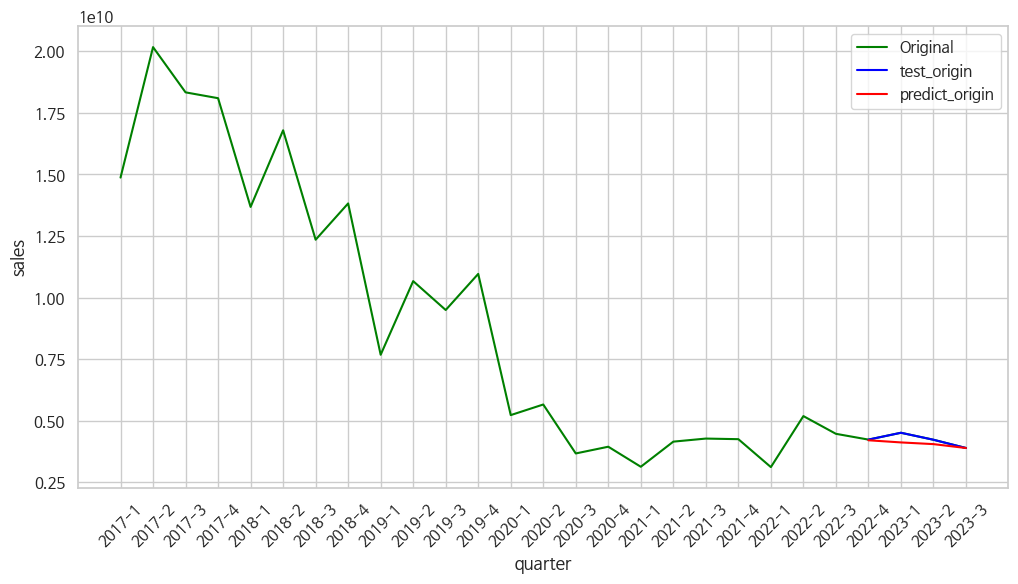

In [183]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('sales')
plt.legend()
plt.show()

In [184]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean     1.492836e+08
std      1.798003e+08
min      0.000000e+00
25%      2.037428e+07
50%      1.025065e+08
75%      2.314158e+08
max      3.921213e+08
dtype: float64

In [185]:
### 23년 4분기 매출 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

sales_pred_last = loaded_model.predict(X_last_test)
print(sales_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
sales = mmsy.inverse_transform(sales_pred_last)[0,0]
print(f'예측된 매출  : {sales} ')

1/1 [==============================] - 0s 44ms/step
[[0.04598749]]
--------------------------------------------------------------------------------
예측된 매출  : 3899194880.0 


### 성장성

In [186]:
X = sin_clothes[['분기당_매출_금액', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['성장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액           시장성    순점포증감률
0   1.487434e+10 -1.923574e+06 -2.024291
1   2.017255e+10  4.282530e+05 -0.406504
2   1.833475e+10  3.864793e+06 -2.286902
3   1.809771e+10  6.838851e+05 -1.476793
4   1.368185e+10 -1.853374e+06 -1.935484
5   1.679379e+10 -2.730931e+06 -0.215517
6   1.234974e+10 -2.090695e+05 -0.869565
7   1.382385e+10 -5.195801e+06 -0.877193
8   7.677671e+09 -3.294589e+06 -2.471910
9   1.066799e+10 -2.422348e+06 -1.136364
10  9.495393e+09  2.349194e+05 -2.320186
11  1.096161e+10 -1.800125e+06 -0.692841
12  5.226683e+09 -3.083545e+06 -2.625298
13  5.657115e+09 -4.613689e+06 -0.968523
14  3.669222e+09 -3.003963e+06 -1.719902
15  3.942652e+09 -5.311729e+06 -2.261307
16  3.128557e+09 -3.875800e+06 -1.295337
17  4.149085e+09 -5.192278e+06 -1.578947
18  4.273441e+09 -2.441964e+06 -1.612903
19  4.249163e+09 -4.963014e+06 -1.917808
20  3.114749e+09 -4.235434e+06 -2.191781
21  5.186498e+09 -8.681121e+06 -0.831025
22  4.467018e+09 -4.267715e+06 -0.837989
23  4.231710e+09

In [187]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [188]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.06514971 0.46665699 0.29562857]
 [0.04544153 0.369078   0.38450584]]


In [189]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [190]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [191]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.2285
Epoch 1: val_loss improved from inf to 0.27883, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.2285 - val_loss: 0.2788
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.2175
Epoch 2: val_loss improved from 0.27883 to 0.27058, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.2175 - val_loss: 0.2706
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2069
Epoch 3: val_loss improved from 0.27058 to 0.26262, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.2069 - val_loss: 0.2626
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1969
Epoch 4: val_loss improved from 0.26262 to 0.25489, saving model to stock_model.h5
1/1 [==============================] - 0s 83ms/step - loss: 0.1969 - val_loss: 0.2549
Epoch 5/100
1/1 [=================

In [192]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 3s 3s/step
[[0.3641187 ]
 [0.37269592]
 [0.33805692]
 [0.30280247]]


In [193]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.395941,0.364119
2023-1,0.378384,0.372696
2023-2,0.324313,0.338057
2023-3,0.302802,0.302802


In [194]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 3].values       # 성장성이 sin_clothes의 index 3번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.395941,0.364119,0.947323,0.909508,3.781517e-02
2023-1,0.378384,0.372696,0.926461,0.919701,6.759822e-03
2023-2,0.324313,0.338057,0.862206,0.878538,-1.633227e-02
2023-3,0.302802,0.302802,0.836645,0.836645,-1.192093e-07


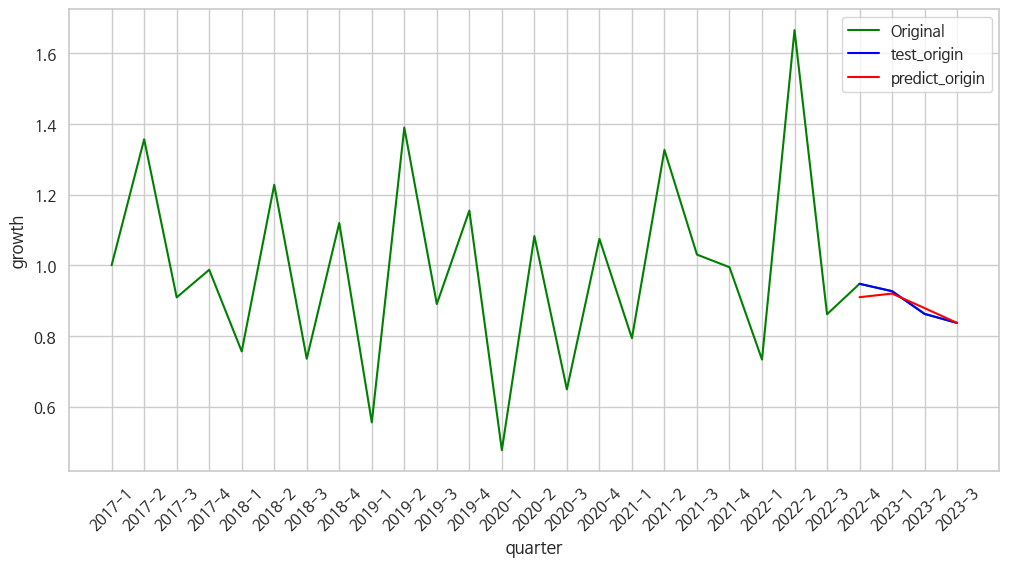

In [195]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['성장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('growth')
plt.legend()
plt.show()

In [196]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.007061
std      0.022679
min     -0.016332
25%     -0.004083
50%      0.003380
75%      0.014524
max      0.037815
dtype: float64

In [197]:
### 23년 4분기 성장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

growth_pred_last = loaded_model.predict(X_last_test)
print(growth_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
growth = mmsy.inverse_transform(growth_pred_last)[0,0]
print(f'예측된 성장성  : {growth} ')

1/1 [==============================] - 0s 38ms/step
[[0.30118856]]
--------------------------------------------------------------------------------
예측된 성장성  : 0.8347267508506775 


###시장성

In [198]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '순점포증감률']]
y = sin_clothes.loc[:,['시장성']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성    순점포증감률
0   1.487434e+10  1.000000 -2.024291
1   2.017255e+10  1.356198 -0.406504
2   1.833475e+10  0.908896 -2.286902
3   1.809771e+10  0.987072 -1.476793
4   1.368185e+10  0.755999 -1.935484
5   1.679379e+10  1.227451 -0.215517
6   1.234974e+10  0.735375 -0.869565
7   1.382385e+10  1.119363 -0.877193
8   7.677671e+09  0.555393 -2.471910
9   1.066799e+10  1.389482 -1.136364
10  9.495393e+09  0.890083 -2.320186
11  1.096161e+10  1.154413 -0.692841
12  5.226683e+09  0.476817 -2.625298
13  5.657115e+09  1.082353 -0.968523
14  3.669222e+09  0.648603 -1.719902
15  3.942652e+09  1.074520 -2.261307
16  3.128557e+09  0.793516 -1.295337
17  4.149085e+09  1.326198 -1.578947
18  4.273441e+09  1.029972 -1.612903
19  4.249163e+09  0.994319 -1.917808
20  3.114749e+09  0.733027 -2.191781
21  5.186498e+09  1.665141 -0.831025
22  4.467018e+09  0.861278 -0.837989
23  4.231710e+09  0.947323 -0.561798
24  4.509229e+09  0.926461 -1.931857
25  4.226060e+09  0.862206 -1.912898
2

In [199]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [200]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.06514971 0.32431295 0.29562857]
 [0.04544153 0.3028024  0.38450584]]


In [201]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [202]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [203]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.4260
Epoch 1: val_loss improved from inf to 0.17706, saving model to stock_model.h5
1/1 [==============================] - 5s 5s/step - loss: 0.4260 - val_loss: 0.1771
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.4105
Epoch 2: val_loss improved from 0.17706 to 0.16986, saving model to stock_model.h5
1/1 [==============================] - 0s 84ms/step - loss: 0.4105 - val_loss: 0.1699
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3956
Epoch 3: val_loss improved from 0.16986 to 0.16292, saving model to stock_model.h5
1/1 [==============================] - 0s 90ms/step - loss: 0.3956 - val_loss: 0.1629
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3811
Epoch 4: val_loss improved from 0.16292 to 0.15621, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.3811 - val_loss: 0.1562
Epoch 5/100
1/1 [=================

In [204]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 782ms/step
[[0.5525024 ]
 [0.49114192]
 [0.4659672 ]
 [0.369078  ]]


In [205]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.000000,0.552502
2023-1,0.487415,0.491142
2023-2,0.466657,0.465967
2023-3,0.369078,0.369078


In [206]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 5].values       # 시장성이 sin_clothes의 index 5번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.000000,0.552502,-1.015001e+07,-2406795.75,-7.743210e+06
2023-1,0.487415,0.491142,-3.318982e+06,-3266750.75,-5.223175e+04
2023-2,0.466657,0.465967,-3.609902e+06,-3619569.00,9.667000e+03
2023-3,0.369078,0.369078,-4.977452e+06,-4977452.00,0.000000e+00


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


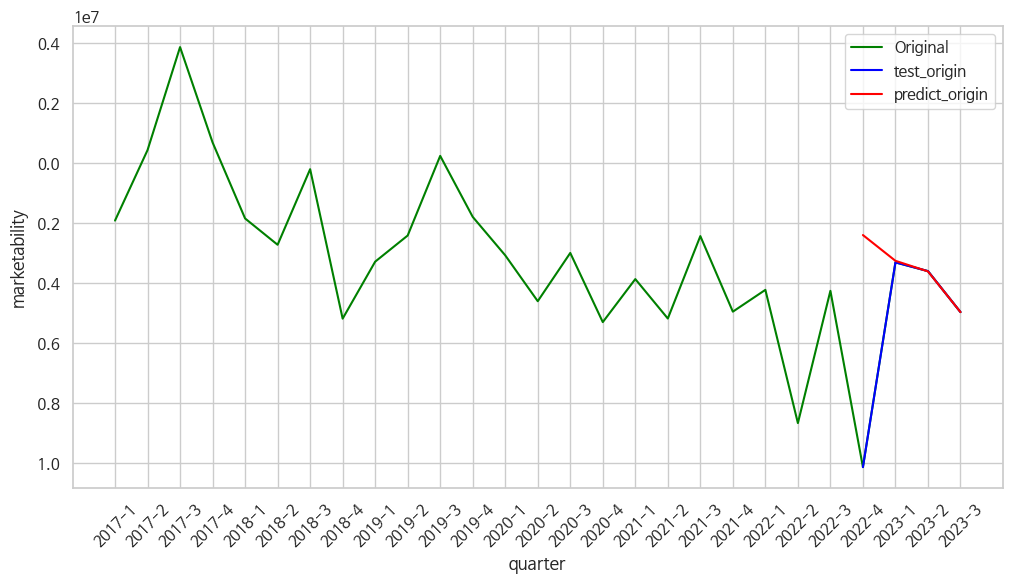

In [207]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['시장성'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('marketability')
plt.legend()
plt.show()

In [208]:
### error의 요약 통계량
error.describe()

count    4.000000e+00
mean    -1.946444e+06
std      3.864607e+06
min     -7.743210e+06
25%     -1.974976e+06
50%     -2.611588e+04
75%      2.416750e+03
max      9.667000e+03
dtype: float64

In [209]:
### 23년 4분기 시장성 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

marketability_pred_last = loaded_model.predict(X_last_test)
print(marketability_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
marketability = mmsy.inverse_transform(marketability_pred_last)[0,0]
print(f'예측된 시장성  : {marketability} ')

1/1 [==============================] - 0s 22ms/step
[[0.36721995]]
--------------------------------------------------------------------------------
예측된 시장성  : -5003492.0 


### 순점포증감률

In [210]:
### X / y 데이터 생성
X = sin_clothes[['분기당_매출_금액', '성장성', '시장성']]
y = sin_clothes.loc[:,['순점포증감률']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

       분기당_매출_금액       성장성           시장성
0   1.487434e+10  1.000000 -1.923574e+06
1   2.017255e+10  1.356198  4.282530e+05
2   1.833475e+10  0.908896  3.864793e+06
3   1.809771e+10  0.987072  6.838851e+05
4   1.368185e+10  0.755999 -1.853374e+06
5   1.679379e+10  1.227451 -2.730931e+06
6   1.234974e+10  0.735375 -2.090695e+05
7   1.382385e+10  1.119363 -5.195801e+06
8   7.677671e+09  0.555393 -3.294589e+06
9   1.066799e+10  1.389482 -2.422348e+06
10  9.495393e+09  0.890083  2.349194e+05
11  1.096161e+10  1.154413 -1.800125e+06
12  5.226683e+09  0.476817 -3.083545e+06
13  5.657115e+09  1.082353 -4.613689e+06
14  3.669222e+09  0.648603 -3.003963e+06
15  3.942652e+09  1.074520 -5.311729e+06
16  3.128557e+09  0.793516 -3.875800e+06
17  4.149085e+09  1.326198 -5.192278e+06
18  4.273441e+09  1.029972 -2.441964e+06
19  4.249163e+09  0.994319 -4.963014e+06
20  3.114749e+09  0.733027 -4.235434e+06
21  5.186498e+09  1.665141 -8.681121e+06
22  4.467018e+09  0.861278 -4.267715e+06
23  4.231710e+09

In [211]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (27, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (27, 1)


In [212]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (25, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (25, 1)
[[0.06514971 0.32431295 0.46665699]
 [0.04544153 0.3028024  0.369078  ]]


In [213]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (21, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (21, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (21, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [214]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_31 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [215]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3521
Epoch 1: val_loss improved from inf to 0.23895, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3521 - val_loss: 0.2389
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3392
Epoch 2: val_loss improved from 0.23895 to 0.23094, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.3392 - val_loss: 0.2309
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3269
Epoch 3: val_loss improved from 0.23094 to 0.22315, saving model to stock_model.h5
1/1 [==============================] - 0s 85ms/step - loss: 0.3269 - val_loss: 0.2232
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3150
Epoch 4: val_loss improved from 0.22315 to 0.21557, saving model to stock_model.h5
1/1 [==============================] - 0s 89ms/step - loss: 0.3150 - val_loss: 0.2156
Epoch 5/100
1/1 [=================

In [216]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 825ms/step
[[0.3765945 ]
 [0.3319121 ]
 [0.31076297]
 [0.38450587]]


In [217]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2022-4,0.856302,0.376595
2023-1,0.287761,0.331912
2023-2,0.295629,0.310763
2023-3,0.384506,0.384506


In [218]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 4].values       # 순점포증감률이 sin_clothes의 index 4번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2022-4,0.856302,0.376595,-0.561798,-1.717788,1.155990
2023-1,0.287761,0.331912,-1.931857,-1.825463,-0.106394
2023-2,0.295629,0.310763,-1.912898,-1.876428,-0.036471
2023-3,0.384506,0.384506,-1.698723,-1.698723,0.000000


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


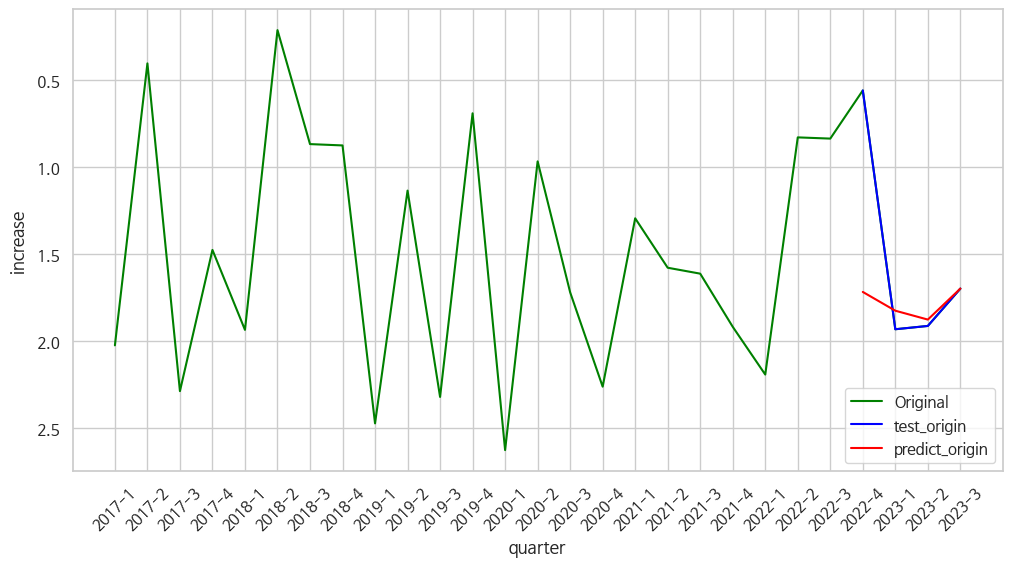

In [219]:
df_test = df_test.reset_index()

### 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['순점포증감률'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.xticks(rotation=45)
plt.xlabel('quarter')
plt.ylabel('increase')
plt.legend()
plt.show()

In [220]:
### error의 요약 통계량
error.describe()

count    4.000000
mean     0.253281
std      0.603423
min     -0.106394
25%     -0.053951
50%     -0.018235
75%      0.288998
max      1.155990
dtype: float64

In [221]:
### 23년 2분기 순점포증감률 예측하기 --> 마지막 테스트 데이터 이용

# 모양 변환
X_last_test = X_last_test.reshape((1,2,3))

increase_pred_last = loaded_model.predict(X_last_test)
print(increase_pred_last)

print('-'*80)

# 스케일링 이전의 상태로 복원
increase = mmsy.inverse_transform(increase_pred_last)[0,0]
print(f'예측된 순점포증감률  : {increase} ')

1/1 [==============================] - 0s 24ms/step
[[0.36377007]]
--------------------------------------------------------------------------------
예측된 순점포증감률  : -1.7486921548843384 


### 추가

In [222]:
sin_clothes.loc[27] = ['2023-4', '일반의류', sales, growth, increase, marketability]

<ipython-input-222-94e42d410254>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sin_clothes.loc[27] = ['2023-4', '일반의류', sales, growth, increase, marketability]


In [223]:
final_sin_clothes = sin_clothes
final_sin_clothes

,분기,업종명,분기당_매출_금액,성장성,순점포증감률,시장성
0,2017-1,일반의류,1.487434e+10,1.000000,-2.024291,-1.923574e+06
1,2017-2,일반의류,2.017255e+10,1.356198,-0.406504,4.282530e+05
2,2017-3,일반의류,1.833475e+10,0.908896,-2.286902,3.864793e+06
3,2017-4,일반의류,1.809771e+10,0.987072,-1.476793,6.838851e+05
4,2018-1,일반의류,1.368185e+10,0.755999,-1.935484,-1.853374e+06
5,2018-2,일반의류,1.679379e+10,1.227451,-0.215517,-2.730931e+06
6,2018-3,일반의류,1.234974e+10,0.735375,-0.869565,-2.090695e+05
7,2018-4,일반의류,1.382385e+10,1.119363,-0.877193,-5.195801e+06
8,2019-1,일반의류,7.677671e+09,0.555393,-2.471910,-3.294589e+06
9,2019-2,일반의류,1.066799e+10,1.389482,-1.136364,-2.422348e+06


## 최종결과

In [224]:
### X / y 데이터 생성
X = sin_clothes[['성장성', '시장성', '순점포증감률']]
y = sin_clothes.loc[:,['분기당_매출_금액']]

# 결과 확인하기
print(X)
print('-'*80)
print(y)

         성장성           시장성    순점포증감률
0   1.000000 -1.923574e+06 -2.024291
1   1.356198  4.282530e+05 -0.406504
2   0.908896  3.864793e+06 -2.286902
3   0.987072  6.838851e+05 -1.476793
4   0.755999 -1.853374e+06 -1.935484
5   1.227451 -2.730931e+06 -0.215517
6   0.735375 -2.090695e+05 -0.869565
7   1.119363 -5.195801e+06 -0.877193
8   0.555393 -3.294589e+06 -2.471910
9   1.389482 -2.422348e+06 -1.136364
10  0.890083  2.349194e+05 -2.320186
11  1.154413 -1.800125e+06 -0.692841
12  0.476817 -3.083545e+06 -2.625298
13  1.082353 -4.613689e+06 -0.968523
14  0.648603 -3.003963e+06 -1.719902
15  1.074520 -5.311729e+06 -2.261307
16  0.793516 -3.875800e+06 -1.295337
17  1.326198 -5.192278e+06 -1.578947
18  1.029972 -2.441964e+06 -1.612903
19  0.994319 -4.963014e+06 -1.917808
20  0.733027 -4.235434e+06 -2.191781
21  1.665141 -8.681121e+06 -0.831025
22  0.861278 -4.267715e+06 -0.837989
23  0.947323 -1.015001e+07 -0.561798
24  0.926461 -3.318982e+06 -1.931857
25  0.862206 -3.609902e+06 -1.912898
2

In [225]:
### Normalization 진행

# MinMaxScaler 임폴트
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성
mmsx = MinMaxScaler()
mmsy = MinMaxScaler()

# 스케일링 실행
X_mms = mmsx.fit_transform(X)
y_mms = mmsy.fit_transform(y)

#  결과 확인하기
print(f'X_mms 모양 : {X_mms.shape}')
print('-'*80)
print(f'y_mms의 모양 : {y_mms.shape}')

X_mms 모양 : (28, 3)
--------------------------------------------------------------------------------
y_mms의 모양 : (28, 1)


In [226]:
# window_size=2인 X, y 데이터 생성
X_data, y_data = make_dataset(X_mms, y_mms, 2)

# 결과 확인하기
print(f'X_data 데이터의 모양 : {X_data.shape}')
print('-'*80)
print(f'y_data 데이터의 모양 : {y_data.shape}')


### 시계열 분석에서 마지막 테스트 데이터 생성
X_last_test = make_last_dataset(X_mms, 2)
print(X_last_test)

X_data 데이터의 모양 : (26, 2, 3)
--------------------------------------------------------------------------------
y_data 데이터의 모양 : (26, 1)
[[0.3028024  0.369078   0.38450584]
 [0.30118854 0.36721996 0.36377004]]


In [227]:
# 평가용 데이터 크기 설정
TEST_SIZE = 4

# 학습용 데이터 생성
X_train = X_data[:-TEST_SIZE, :, :]
y_train = y_data[:-TEST_SIZE, :]

# 평가용 데이터 생성
X_test = X_data[-TEST_SIZE:, :, :]
y_test = y_data[-TEST_SIZE:, :]

## 학습용 데이터를 학습용과 검증용으로 분할

# 필요한 함수 임폴트
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

# 결과 확인하기
print(f'학습용 데이터의 모양 : {X_train.shape}')
print('-'*80)
print(f'학습용 레이블의 모양 : {y_train.shape}')
print('-'*80)
# print(f'검증용 데이터의 모양 : {X_valid.shape}')
# print('-'*80)
# print(f'검증용 레이블의 모양 : {y_valid.shape}')
# print('-'*80)
print(f'평가용 데이터의 모양 : {X_test.shape}')
print('-'*80)
print(f'평가용 레이블의 모양 : {y_test.shape}')

# 결과 확인하기
print(f'X_train의 모양 : {X_train.shape}')
print('-'*80)
print(f'y_train의 모양 : {y_train.shape}')
print('-'*80)
print(f'X_test의 모양 : {X_test.shape}')
print('-'*80)
print(f'y_test의 모양 : {y_test.shape}')

학습용 데이터의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
학습용 레이블의 모양 : (22, 1)
--------------------------------------------------------------------------------
평가용 데이터의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
평가용 레이블의 모양 : (4, 1)
X_train의 모양 : (22, 2, 3)
--------------------------------------------------------------------------------
y_train의 모양 : (22, 1)
--------------------------------------------------------------------------------
X_test의 모양 : (4, 2, 3)
--------------------------------------------------------------------------------
y_test의 모양 : (4, 1)


In [228]:
# 랜덤 시드 설정
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# 모델 정의
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64,
                               return_sequences=True,
                               kernel_initializer=initializer,
                               input_shape=X_train[0].shape))
model.add(tf.keras.layers.LSTM(units=32, kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.001))

# 모델 확인
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 2, 64)             17408     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [229]:
# 과대 적합을 방지하기 위한 조기 종료 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              verbose=1,
                                              patience=2)

# 최적의 학습 결과를 저장하기 위한 ModelCheckpoint 설정
save_file_path = 'stock_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

# 학습 진행
history = model.fit(X_train,
                    y_train,
                    # batch_size=256,
                    epochs=100,
                    validation_split=0.4,
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3374
Epoch 1: val_loss improved from inf to 0.00600, saving model to stock_model.h5
1/1 [==============================] - 6s 6s/step - loss: 0.3374 - val_loss: 0.0060
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3245
Epoch 2: val_loss improved from 0.00600 to 0.00462, saving model to stock_model.h5
1/1 [==============================] - 0s 86ms/step - loss: 0.3245 - val_loss: 0.0046
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3122
Epoch 3: val_loss improved from 0.00462 to 0.00350, saving model to stock_model.h5
1/1 [==============================] - 0s 104ms/step - loss: 0.3122 - val_loss: 0.0035
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3003
Epoch 4: val_loss improved from 0.00350 to 0.00261, saving model to stock_model.h5
1/1 [==============================] - 0s 88ms/step - loss: 0.3003 - val_loss: 0.0026
Epoch 5/100
1/1 [================

In [230]:
# 학습된 모델을 불러오기
loaded_model = tf.keras.models.load_model('stock_model.h5')

# 테스트 데이터를 이용하여 예측하기
pred = loaded_model.predict(X_test)
print(pred)

1/1 [==============================] - 1s 788ms/step
[[0.05872202]
 [0.05468137]
 [0.04541598]
 [0.04596256]]


In [231]:
## 평가용 데이터에 대한 예측의 결과 --> 데이터프레임 생성
df_test = pd.DataFrame(y_test, columns=['y_test'])
df_test['predict'] = pred
date = sin_clothes.iloc[-4:, 0]
df_test.index = date

# 결과 확인하기
df_test

,y_test,predict
분기,,
2023-1,0.081750,0.058722
2023-2,0.065150,0.054681
2023-3,0.045442,0.045416
2023-4,0.045987,0.045963


In [232]:
### 평가용 데이터에 대한 예측의 결과 --> 스케일링 이전의 상태로 복원
predict_inverse = mmsy.inverse_transform(pred)
df_test['test_origin'] = sin_clothes.iloc[-len(pred):, 2].values       # 분기당 매출 금액이 sin_clothes의 index 2번 자리에 있음
df_test['predict_origin'] = predict_inverse
error = df_test['test_origin'] - df_test['predict_origin']
df_test['error'] = error

# 결과 확인하기
df_test

,y_test,predict,test_origin,predict_origin,error
분기,,,,,
2023-1,0.081750,0.058722,4.509229e+09,4.116418e+09,392810496.0
2023-2,0.065150,0.054681,4.226060e+09,4.047493e+09,178566912.0
2023-3,0.045442,0.045416,3.889882e+09,3.889446e+09,435968.0
2023-4,0.045987,0.045963,3.899195e+09,3.898770e+09,425216.0


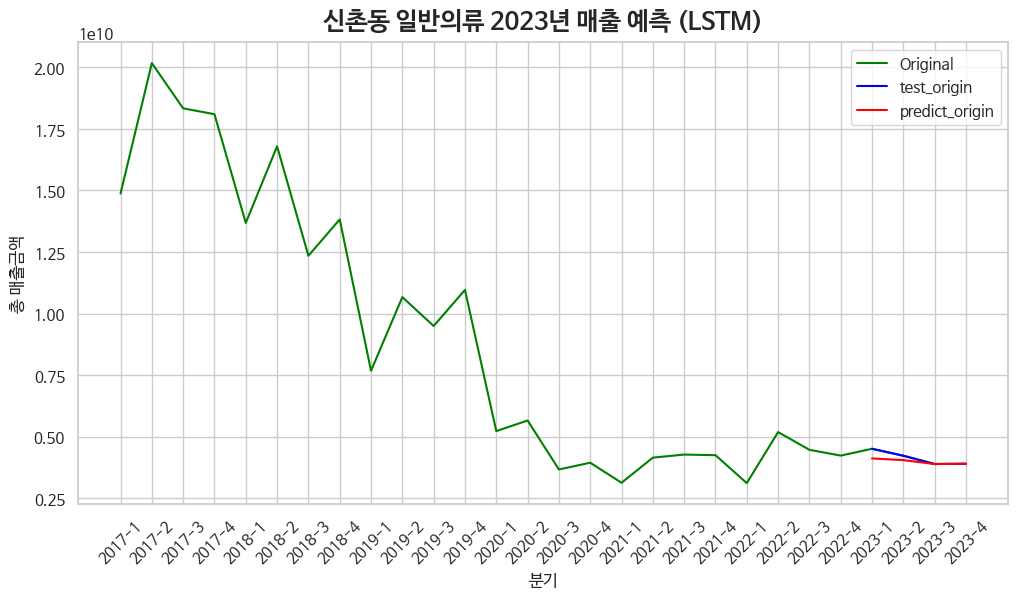

In [233]:
df_test = df_test.reset_index()

### 결과 시각화

plt.figure(figsize=(12, 6))
plt.plot(sin_clothes['분기'], sin_clothes['분기당_매출_금액'], color='green', label = 'Original')
plt.plot(df_test['분기'], df_test['test_origin'], color='blue', label = 'test_origin')
plt.plot(df_test['분기'], df_test['predict_origin'], color='red', label = 'predict_origin')
plt.title('신촌동 일반의류 2023년 매출 예측 (LSTM)', fontsize = 18, fontweight='bold', pad =10)
plt.xticks(rotation=45)
plt.xlabel('분기')
plt.ylabel('총 매출금액')
plt.legend()
plt.show()